In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [2]:
input_size = 784
hidden_size0 = 32
hidden_size1 = 16     
out_size = 1 #binary for whether it is digit or not
        
bin_digit = 3
epochs = 10            
batch_size = 64
learning_rate = 0.001

In [3]:
train_dataset = datasets.MNIST(root='./data',
                           train=True,
                           transform=transforms.ToTensor(),
                           download=True)

test_dataset = datasets.MNIST(root='./data',
                           train=False,
                           transform=transforms.ToTensor())

In [4]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [5]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size0, hidden_size1, out_size):
        super(Net, self).__init__()
        self.fc0 = nn.Linear(input_size, hidden_size0)
        self.fc1 = nn.Linear(hidden_size0, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, out_size)
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        nn.init.kaiming_normal_(self.fc0.weight)
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        
    def forward(self, x): #x = input img
        x = x.view(x.size(0), -1)  #flatten img, because (batch_size, 1, 28, 28) and nn.Linear expects (batch_size, features)
        out = self.relu(self.fc0(x))
        out = self.relu(self.fc1(out))
        out = self.fc2(out)

        return out

In [6]:
#create net
net = Net(input_size, hidden_size0, hidden_size1, out_size)
CUDA = torch.cuda.is_available()
if CUDA:
    net = net.cuda()

#Loss: is it a specific number or not (e.g., 3)?
criterion = nn.BCEWithLogitsLoss() #uses sigmoid

#Optimiser for gradient descent:
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

![Alt Text](<https://miro.medium.com/v2/resize:fit:1003/1*1kCwAuqqte7r3LeiiP1FDQ.jpeg>)


In [7]:
print(CUDA)

True


In [8]:
#the following first used the full train_loader, but I realised it had to be reduced to have equally as many bin_digit's as other digits
#I noticed that when testing the network explanation where the bin_digit itself made it negatively influence the decision that it was the digit
#because it trained 9* more on other digits than on bin_digit, it tended strongly to predict it wasn't the bin_digit!

In [9]:
#train

for epoch in range(epochs):
    correct_train = 0
    running_loss = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, 28*28)

        if CUDA:
            images = images.cuda()
            labels = labels.cuda()

        bin_mask = (labels == bin_digit)
        other_mask = ~bin_mask

        bin_images = images[bin_mask]
        bin_labels = labels[bin_mask]

        other_images = images[other_mask]
        other_labels = labels[other_mask]

        n_bin = bin_images.size(0)

        if n_bin == 0:
            continue

        target_other_per_digit = n_bin

        balanced_other_images = []
        balanced_other_labels = []

        for digit in range(10):
            if digit == bin_digit:
                continue
            digit_mask = (other_labels == digit)
            digit_images = other_images[digit_mask]
            digit_labels = other_labels[digit_mask]

            if digit_images.size(0) < target_other_per_digit and digit_images.size(0) > 0:
                indices = torch.randint(0, digit_images.size(0), (target_other_per_digit,), device=digit_images.device)
            else:
                indices = torch.randperm(digit_images.size(0), device=digit_images.device)[:target_other_per_digit]

            balanced_other_images.append(digit_images[indices])
            balanced_other_labels.append(digit_labels[indices])

        if len(balanced_other_images) == 0:
            continue

        balanced_other_images = torch.cat(balanced_other_images, dim=0)
        balanced_other_labels = torch.cat(balanced_other_labels, dim=0)

        batch_images = torch.cat([bin_images, balanced_other_images], dim=0)
        batch_labels = torch.cat([bin_labels, balanced_other_labels], dim=0)

        perm = torch.randperm(batch_images.size(0), device=batch_images.device)
        batch_images = batch_images[perm]
        batch_labels = batch_labels[perm]

        batch_labels_bin = (batch_labels == bin_digit).float().view(-1, 1)

        outputs = net(batch_images)
        loss = criterion(outputs, batch_labels_bin)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        predicted = (torch.sigmoid(outputs) >= 0.5).float()
        correct_train += (predicted == batch_labels_bin).sum().item()

    accuracy = 100 * correct_train / len(train_dataset)
    print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {running_loss / len(train_loader):.3f}, Training Accuracy: {accuracy:.3f}%')

print("DONE TRAINING!")
torch.save(net.state_dict(), f'binary_ffn_{bin_digit}.pth')


Epoch [1/10], Training Loss: 0.079, Training Accuracy: 99.623%
Epoch [2/10], Training Loss: 0.040, Training Accuracy: 100.673%
Epoch [3/10], Training Loss: 0.030, Training Accuracy: 101.000%
Epoch [4/10], Training Loss: 0.024, Training Accuracy: 101.245%
Epoch [5/10], Training Loss: 0.021, Training Accuracy: 101.353%
Epoch [6/10], Training Loss: 0.016, Training Accuracy: 101.518%
Epoch [7/10], Training Loss: 0.016, Training Accuracy: 101.508%
Epoch [8/10], Training Loss: 0.013, Training Accuracy: 101.630%
Epoch [9/10], Training Loss: 0.011, Training Accuracy: 101.760%
Epoch [10/10], Training Loss: 0.010, Training Accuracy: 101.702%
DONE TRAINING!


In [10]:
#net.load_state_dict(torch.load('binary_ffn.pth'))

In [11]:
with torch.no_grad():
    correct = 0
    for images, labels in test_loader:
        if CUDA:
            images = images.cuda()
            labels = labels.cuda()
        images = images.view(-1, 28*28)
        labels = (labels == bin_digit).float().view(-1, 1)
        outputs = net(images)
        predicted = (torch.sigmoid(outputs) >= 0.5).float()
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / len(test_dataset)))

Accuracy of the network on the 10000 test images: 99.46 %


In [12]:
#failed ~43 here

In [13]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        mask = (labels == bin_digit)
        if not mask.any():
            continue
        images = images[mask]
        labels = labels[mask]
        if CUDA:
            images = images.cuda()
            labels = labels.cuda()
        images = images.view(-1, 28*28)
        labels = torch.ones_like(labels).float().view(-1, 1)
        outputs = net(images)
        predicted = (torch.sigmoid(outputs) >= 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    print(f'Accuracy of the network on digit {bin_digit}: ' + '{:.2f} %'.format(100 * correct / total))


Accuracy of the network on digit 3: 94.95 %


In [14]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.ndimage import gaussian_filter
import random as ra

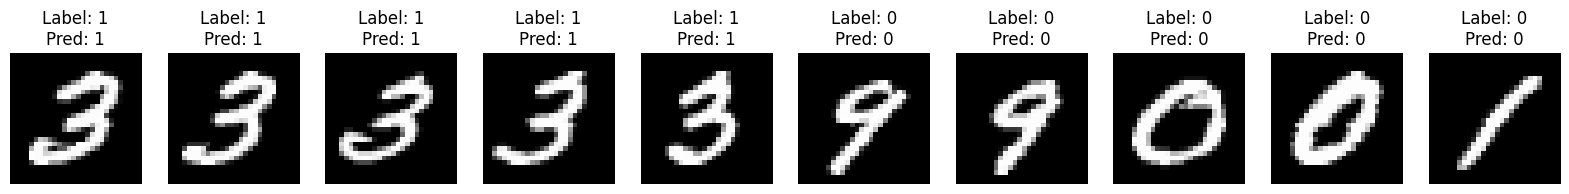

In [15]:
#examples:

net.eval()


data_iter = iter(test_loader)
batch_list = list(data_iter)
random_batch = ra.choice(batch_list)
images, labels = random_batch

pos_idx = (labels == bin_digit).nonzero(as_tuple=True)[0]
neg_idx = (labels != bin_digit).nonzero(as_tuple=True)[0]

n = 10  #how many imgs to display
half_n = n // 2
selected_idx = torch.cat([pos_idx[:half_n], neg_idx[:half_n]])

selected_images = images[selected_idx].cuda()
selected_labels = labels[selected_idx]

inputs = selected_images.view(selected_images.size(0), -1)
outputs = net(inputs)
preds = (torch.sigmoid(outputs) >= 0.5).float().squeeze().cpu() #activate logits out to binary 

plt.figure(figsize=(n * 2, 4))
for i in range(selected_images.size(0)):
    plt.subplot(1, n, i+1)
    plt.imshow(selected_images[i].cpu().squeeze(), cmap='gray')
    plt.title(f'Label: {int(selected_labels[i].item() == bin_digit)}\nPred: {int(preds[i])}')
    plt.axis('off')
plt.show()

In [16]:
#activation maximization, LRP:
from captum.attr import LRP

/home/kns357/Desktop/ann_ma_kaito/venv0/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Text(0.5, 1.0, 'average pixels per digit')

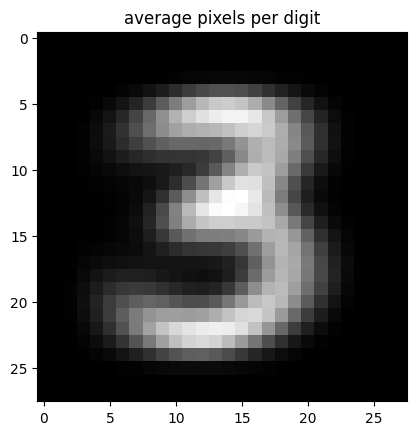

In [17]:
accumulator = np.zeros((1, 28, 28), dtype=np.float64)

count = 0
for img, label in train_dataset:
    if label == bin_digit:
        img = img.numpy()
        arr = np.array(img, dtype=np.float64)
        accumulator += arr
        count += 1

average_img = (accumulator / count).squeeze()
plt.imshow(average_img, cmap="gray")
plt.title("average pixels per digit")

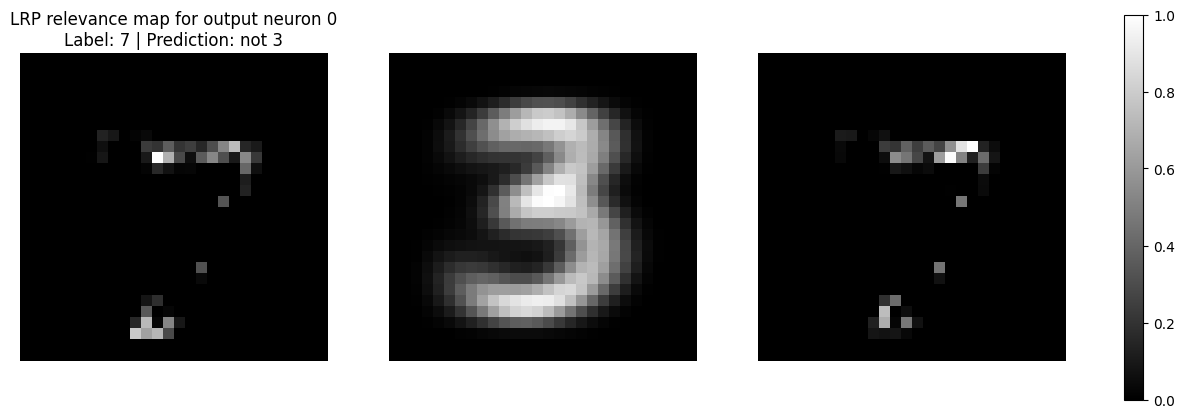

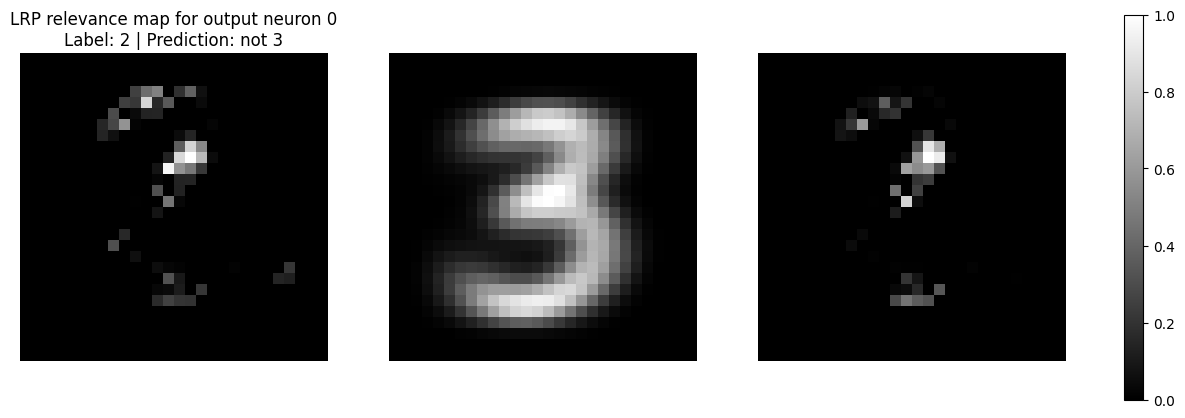

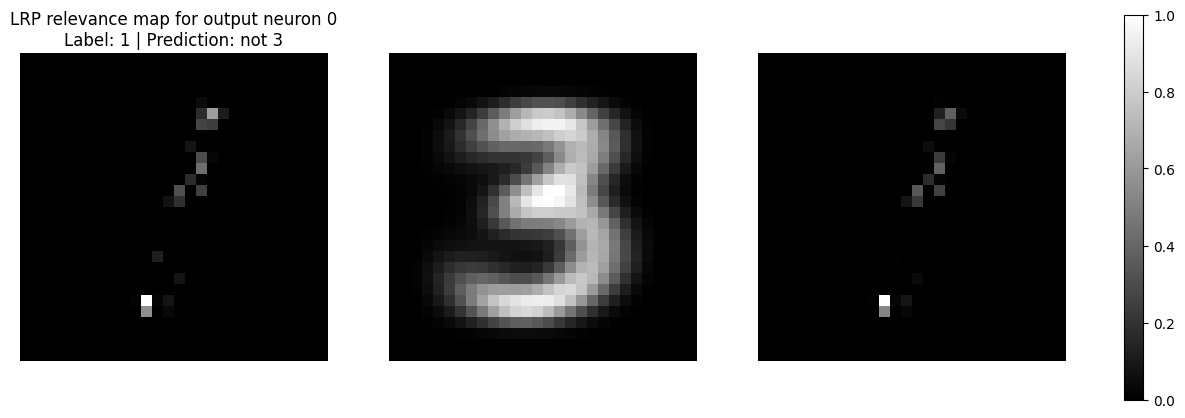

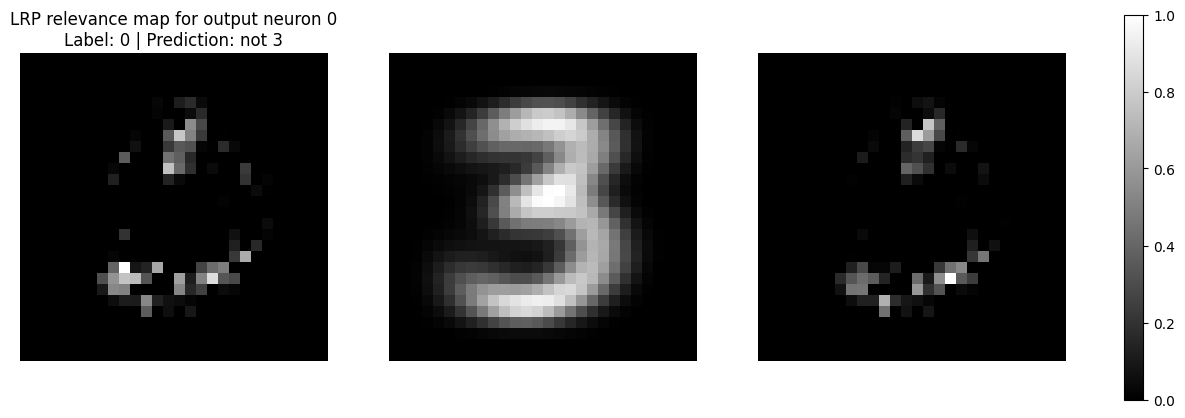

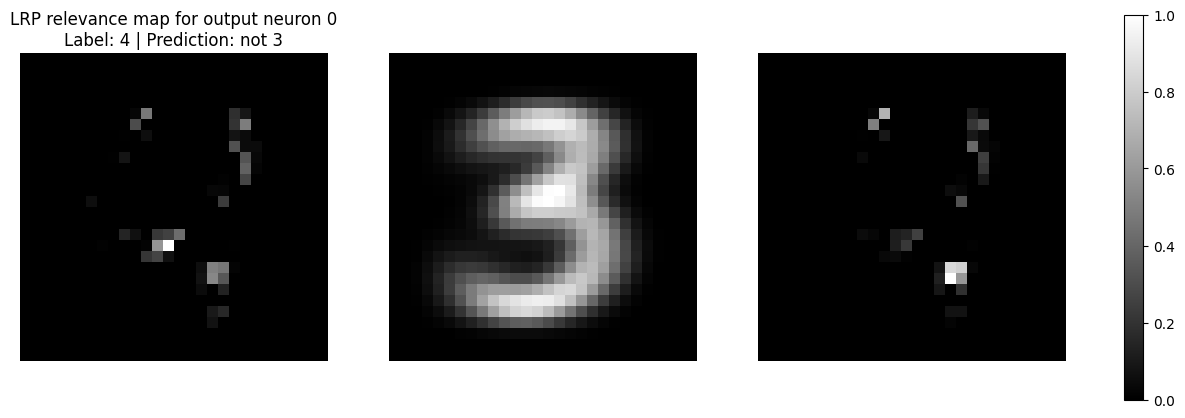

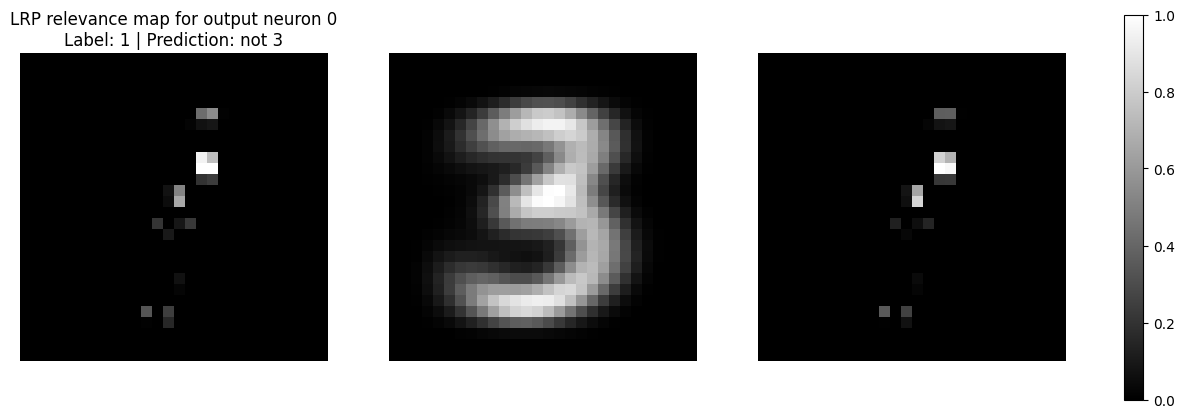

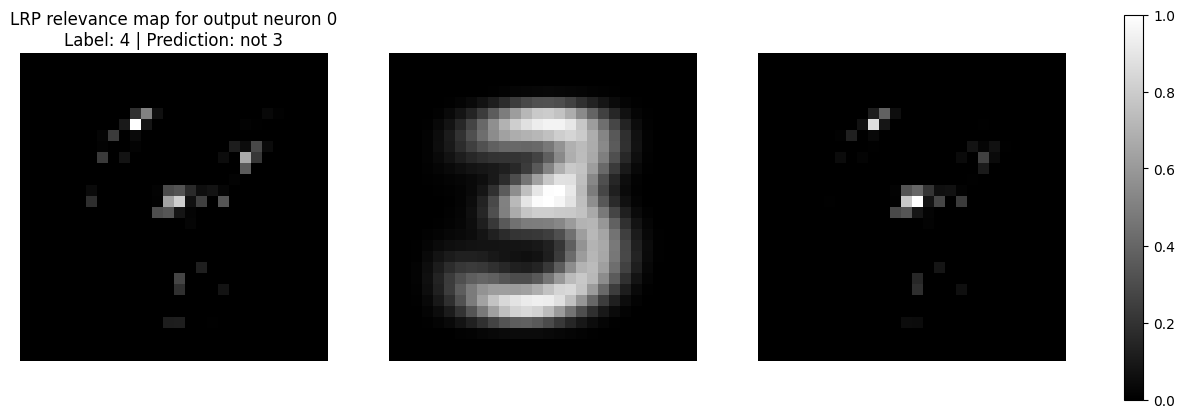

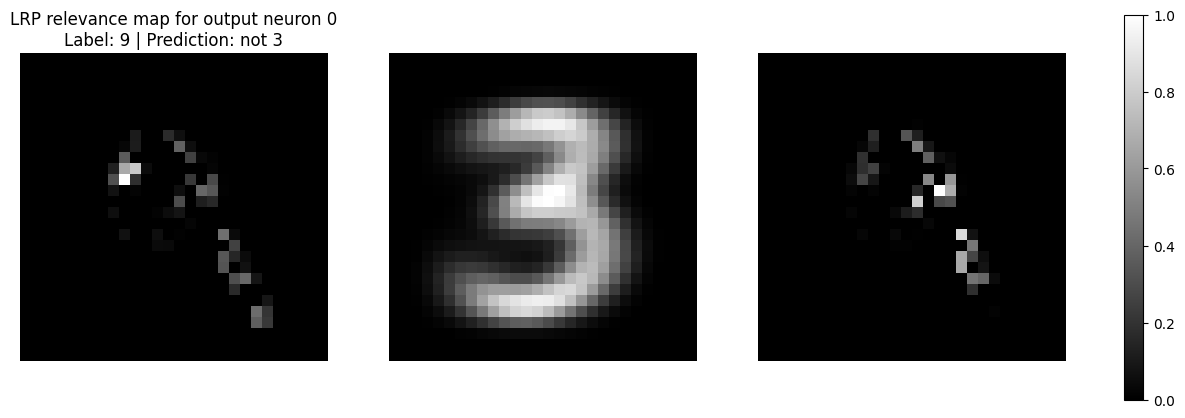

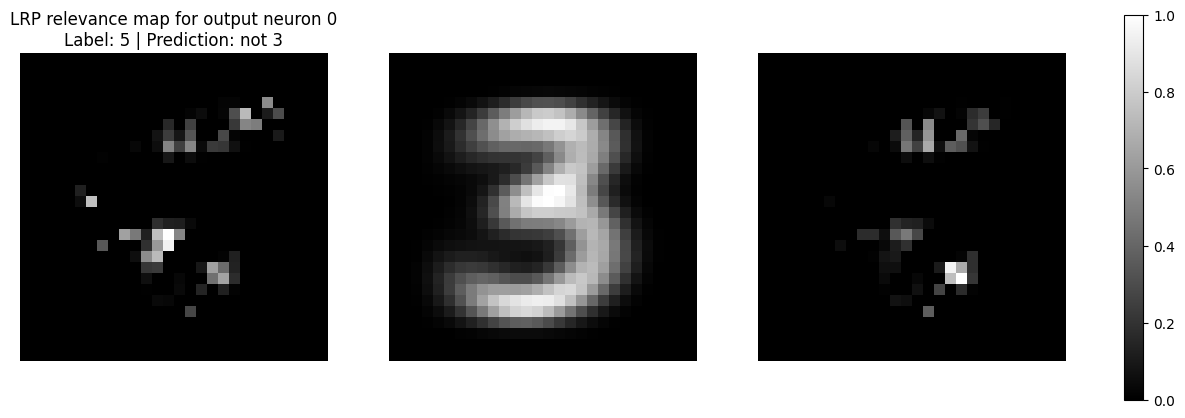

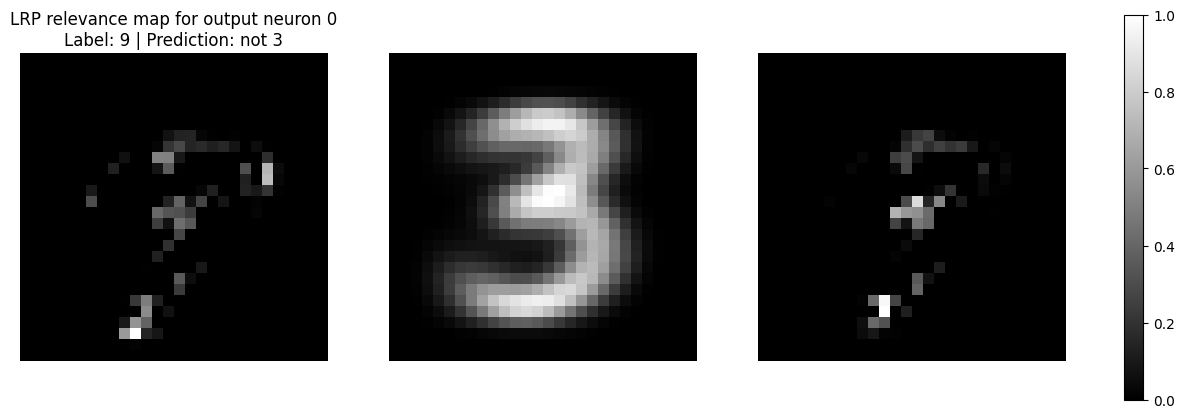

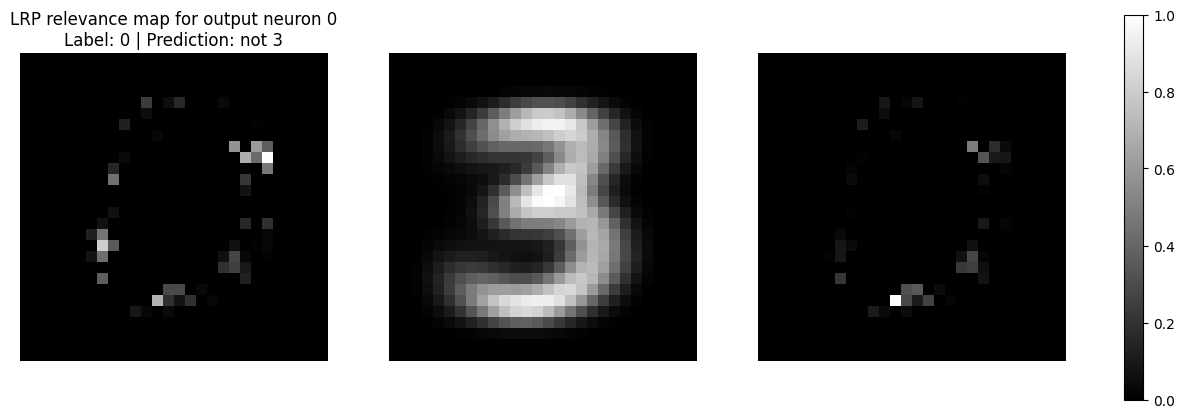

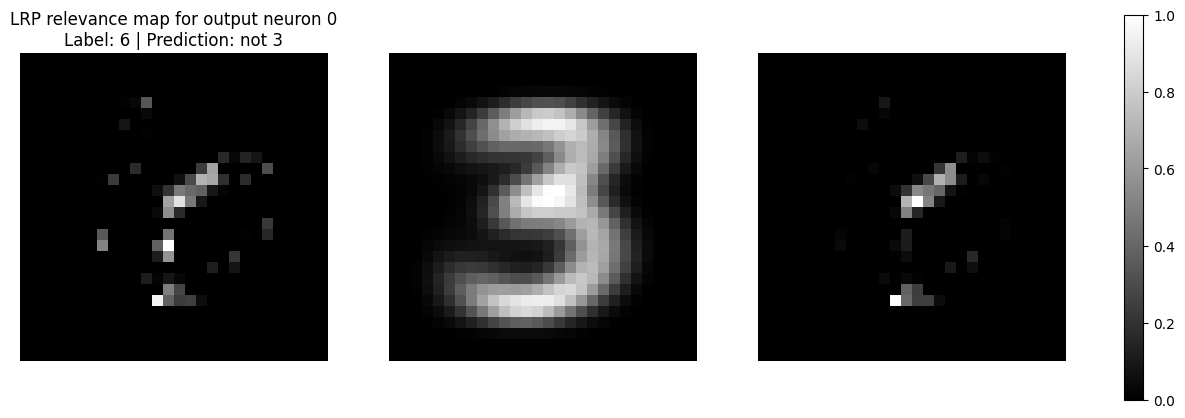

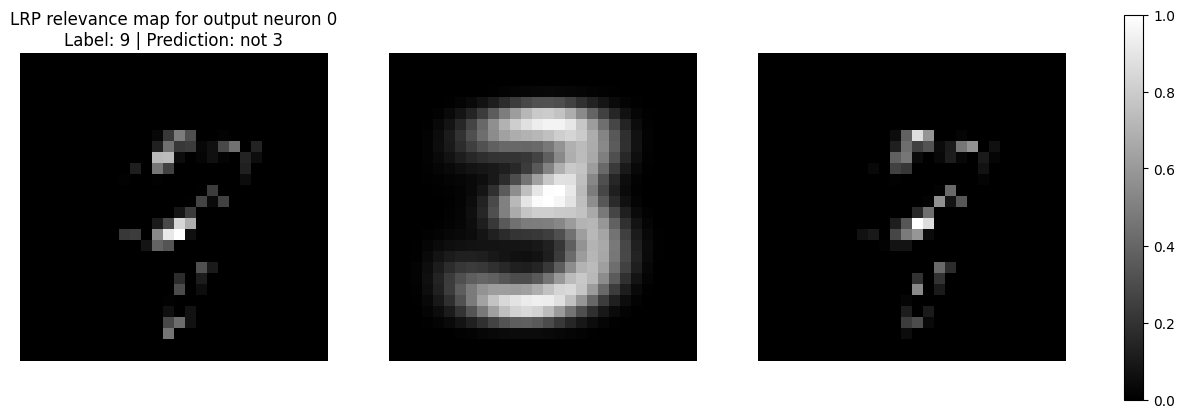

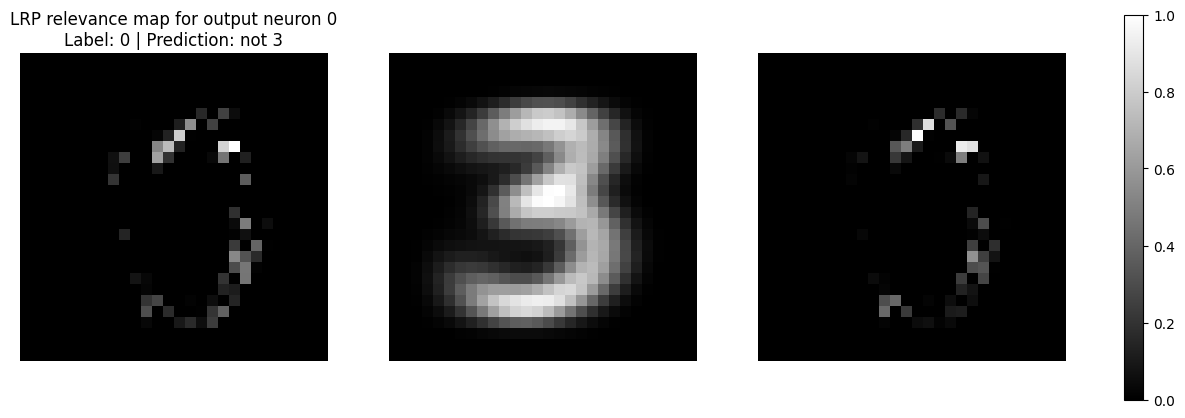

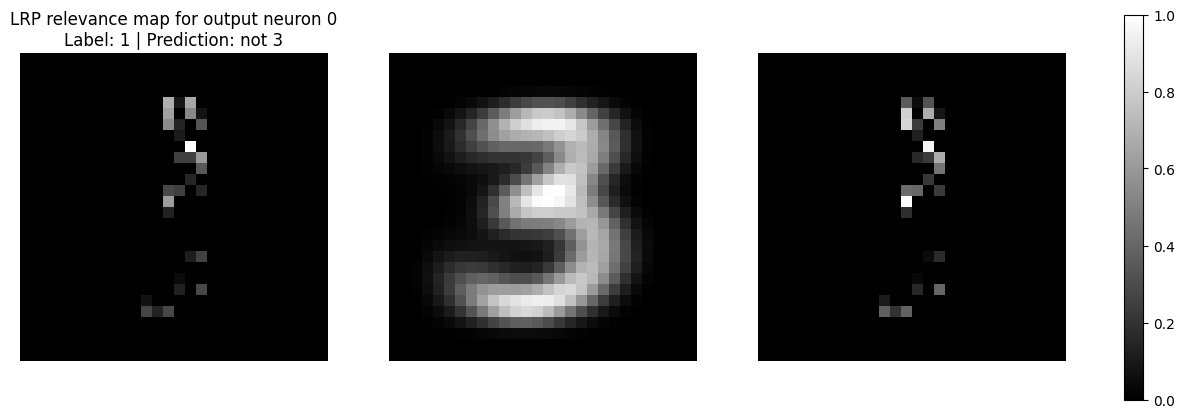

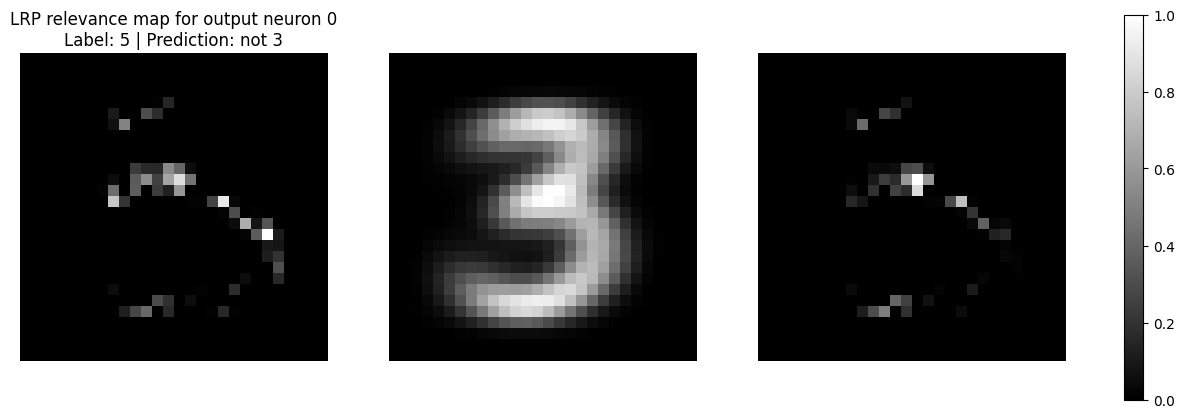

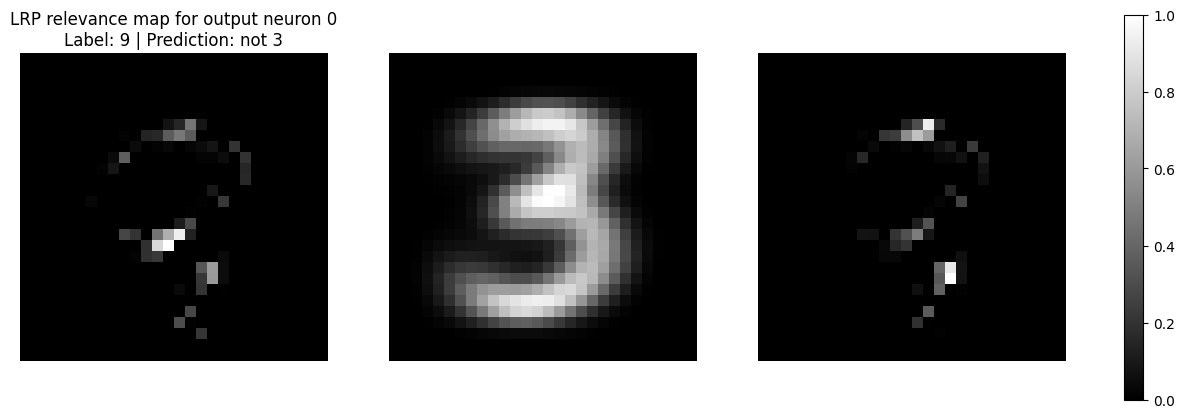

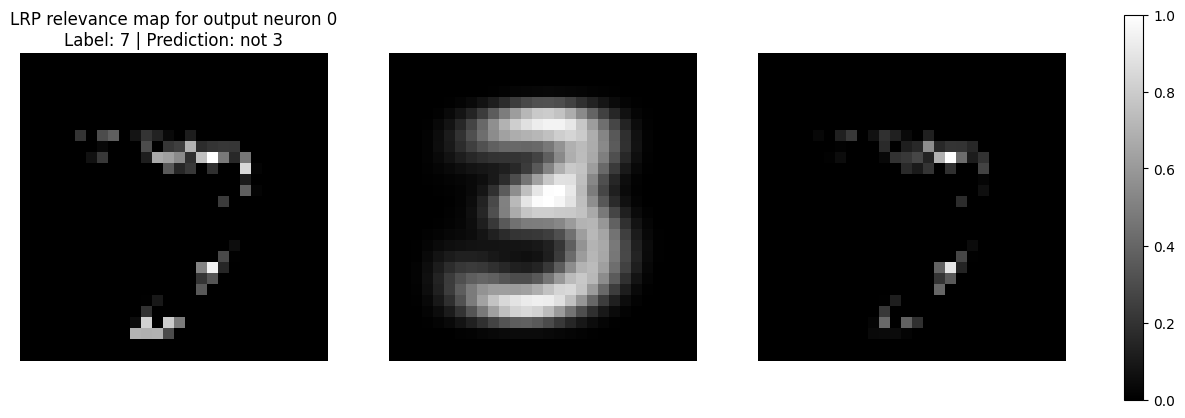

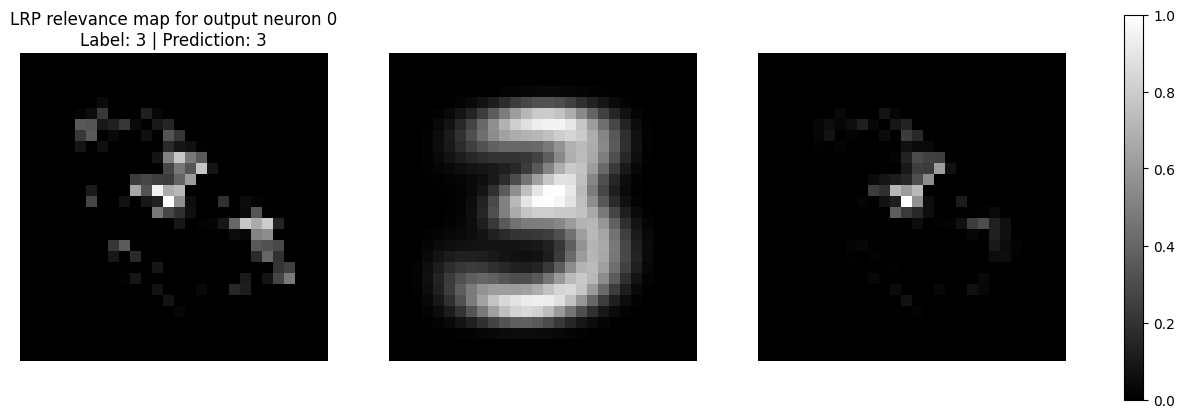

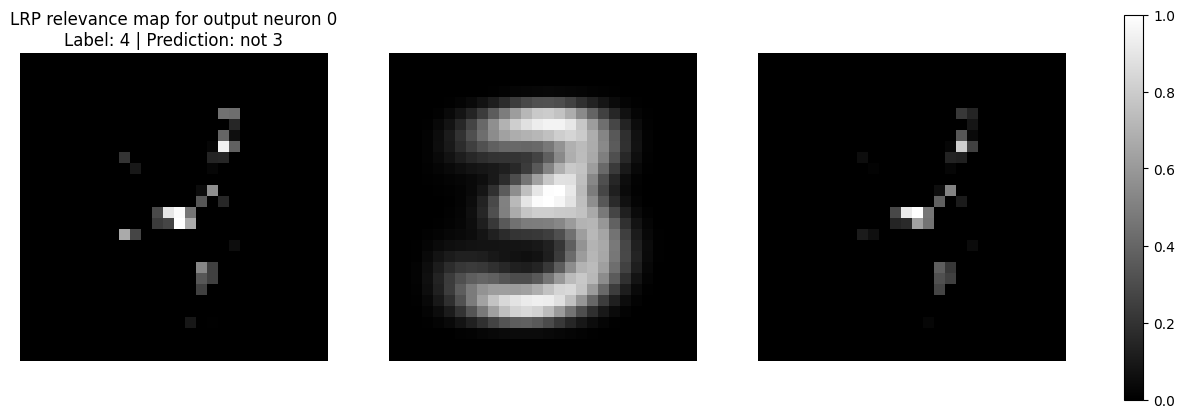

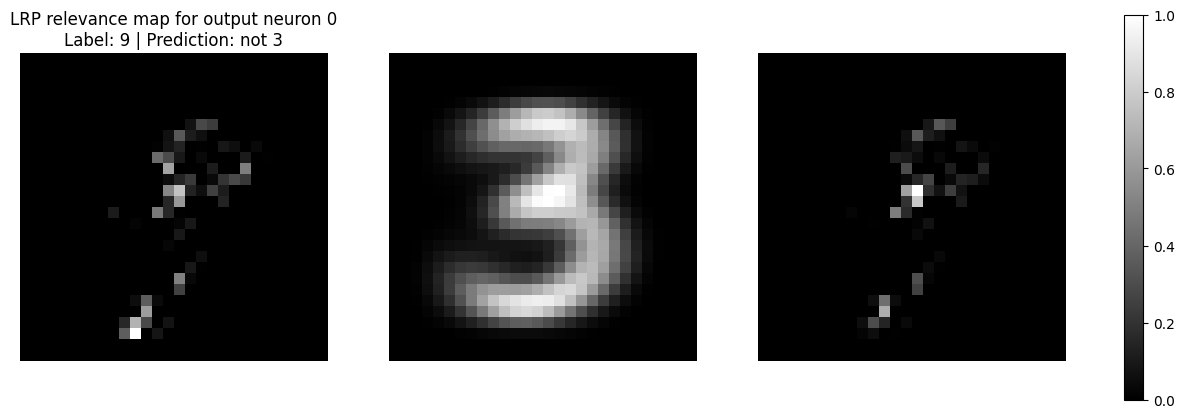

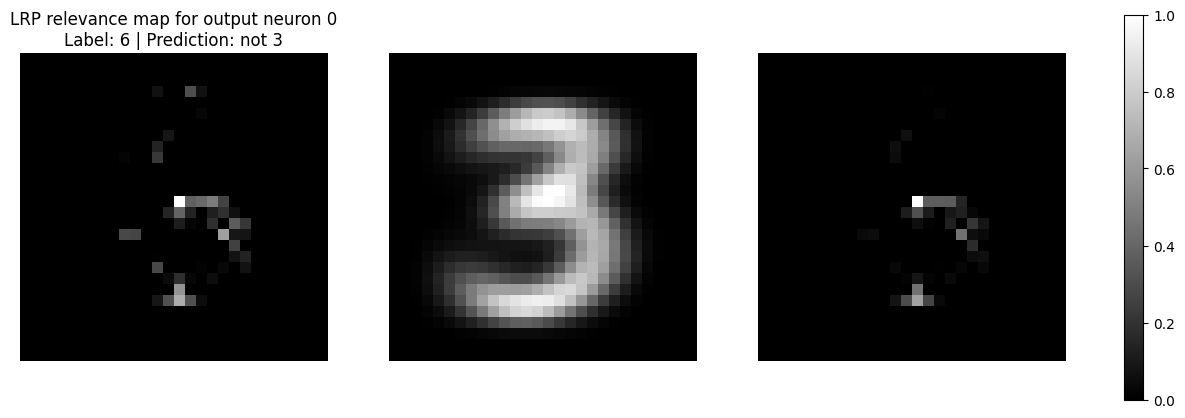

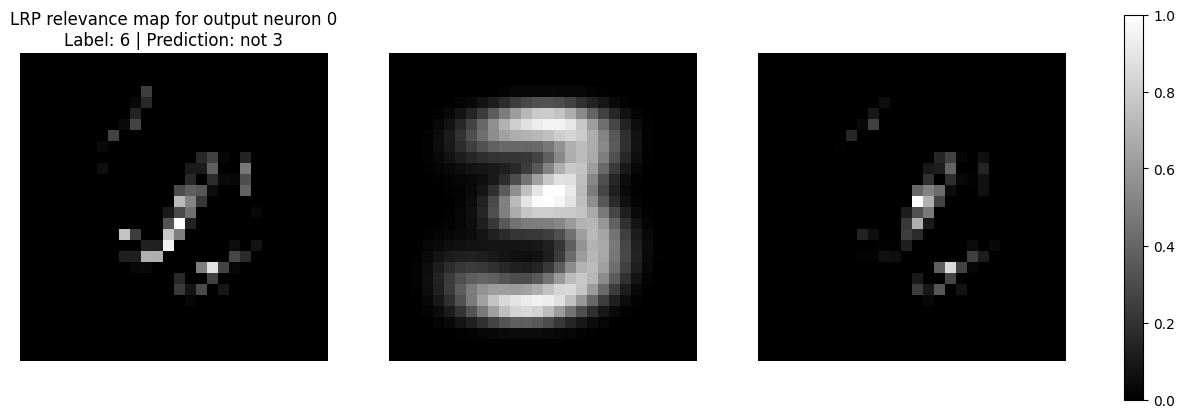

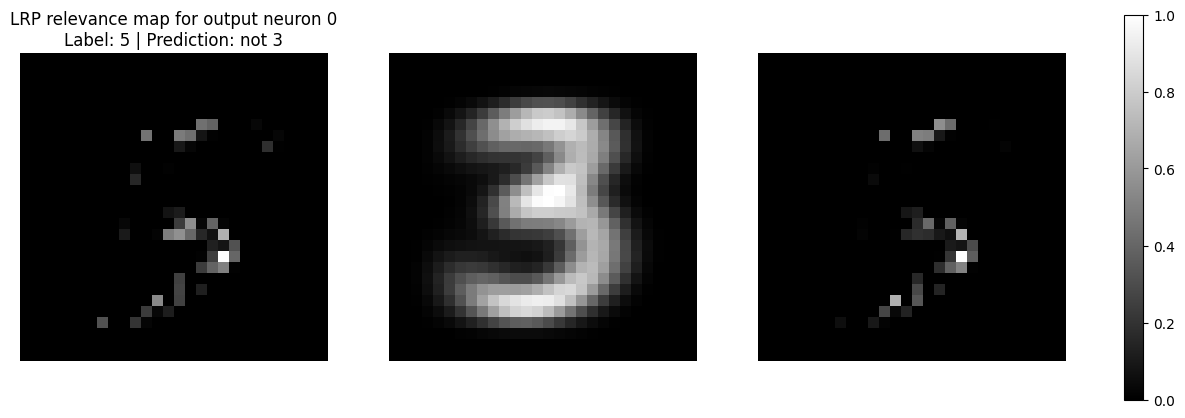

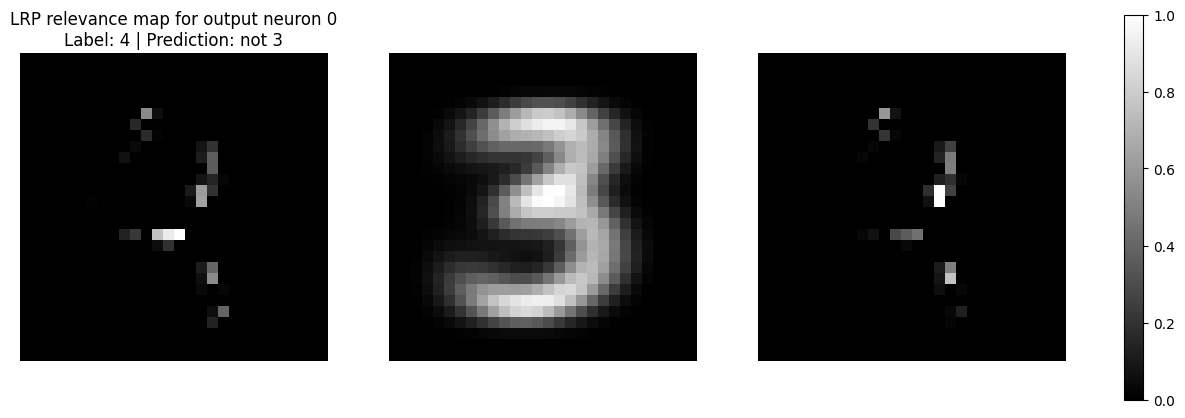

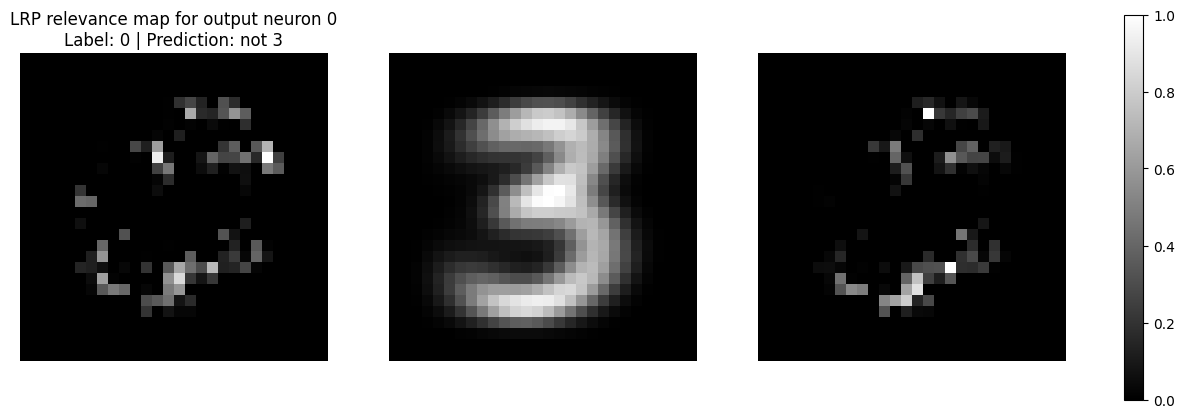

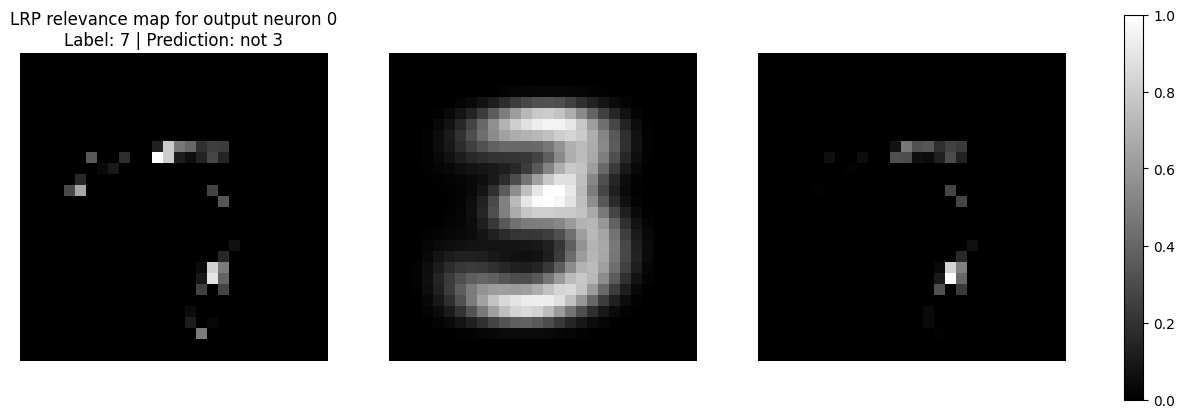

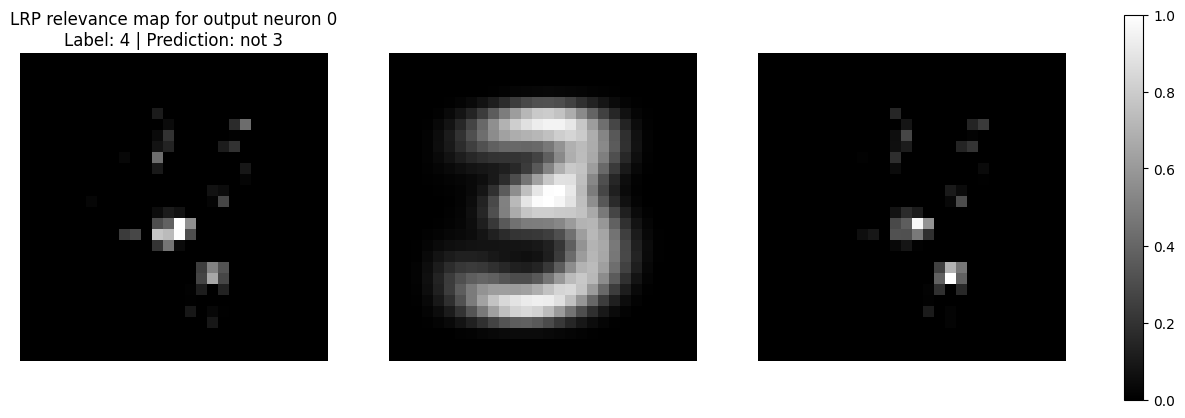

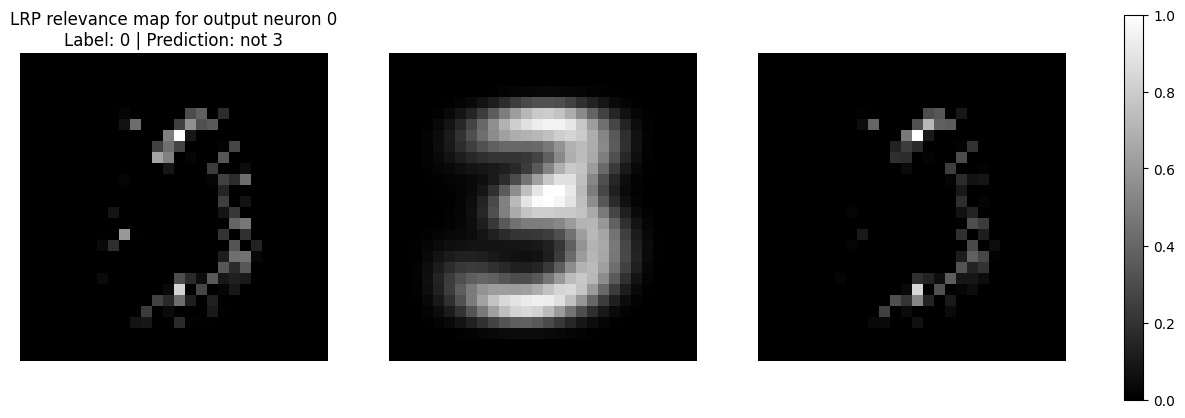

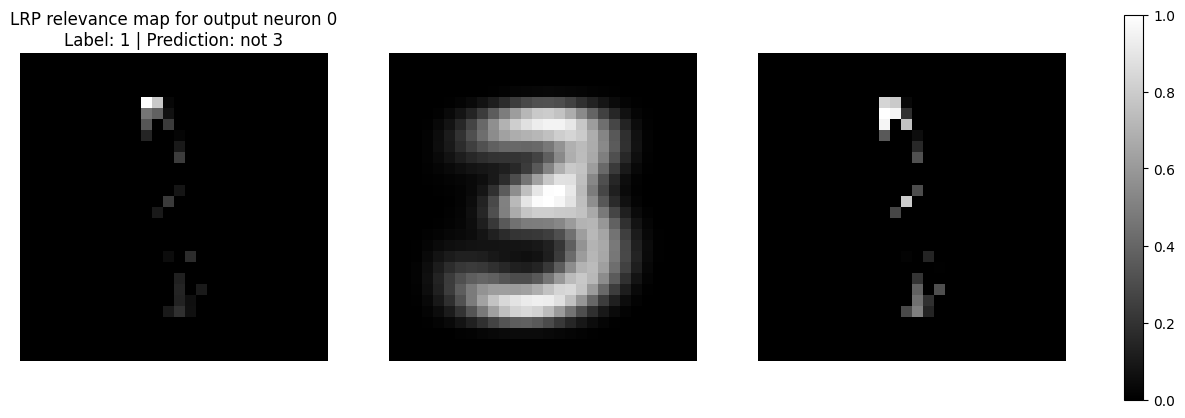

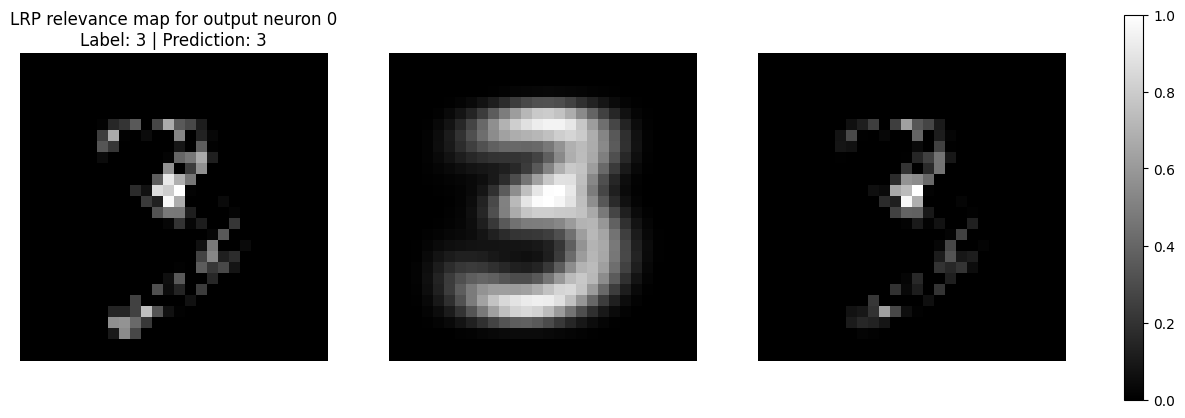

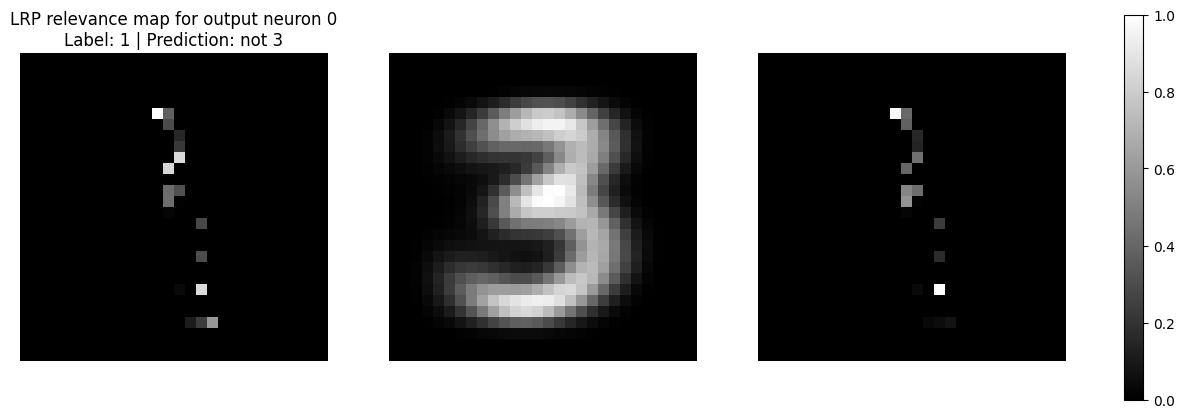

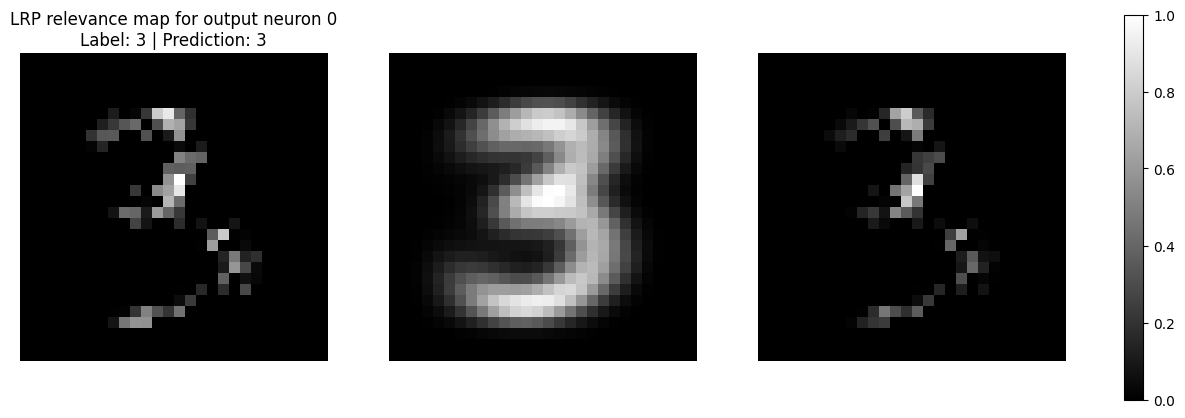

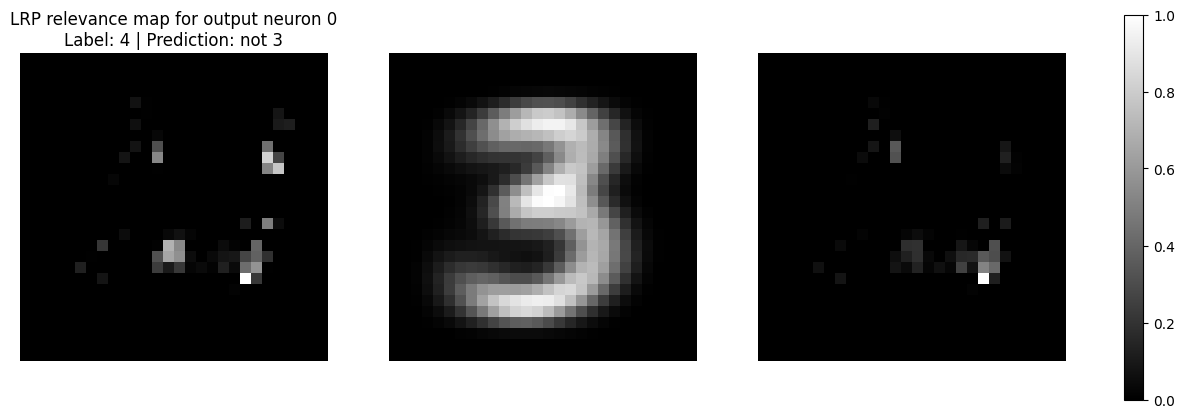

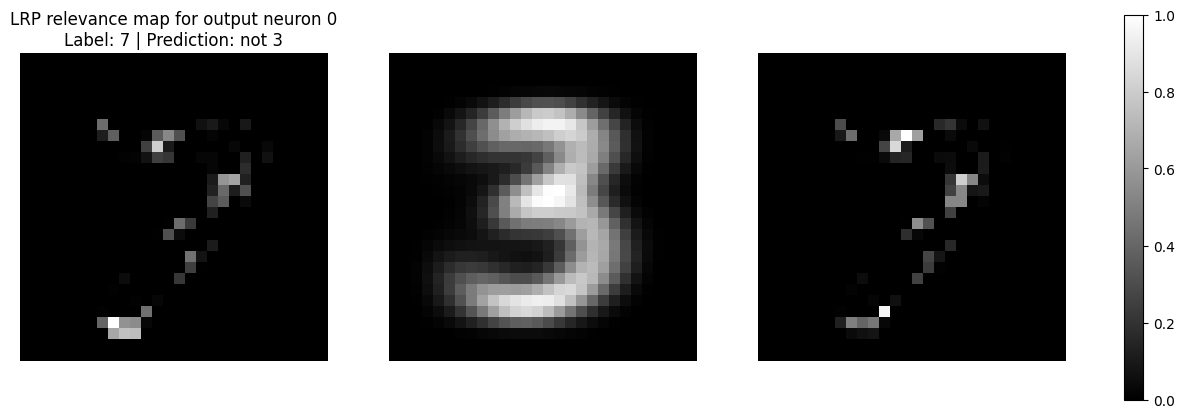

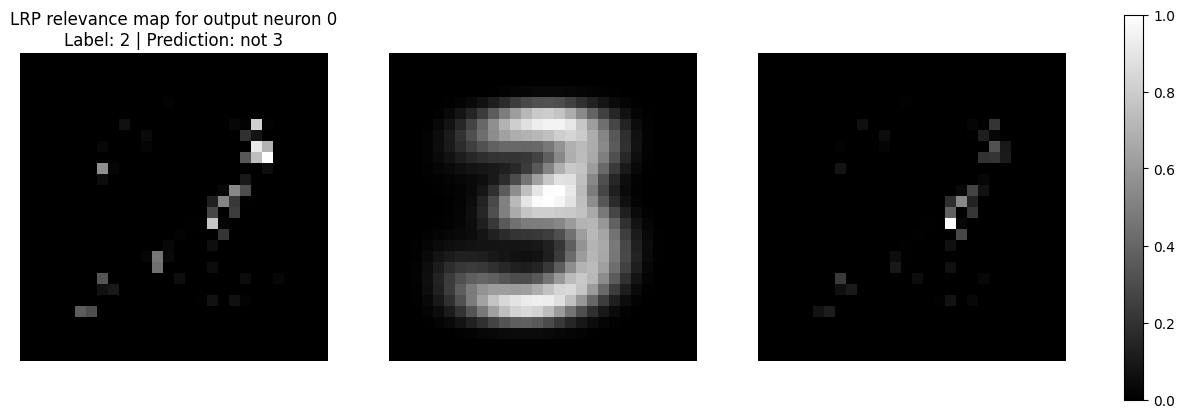

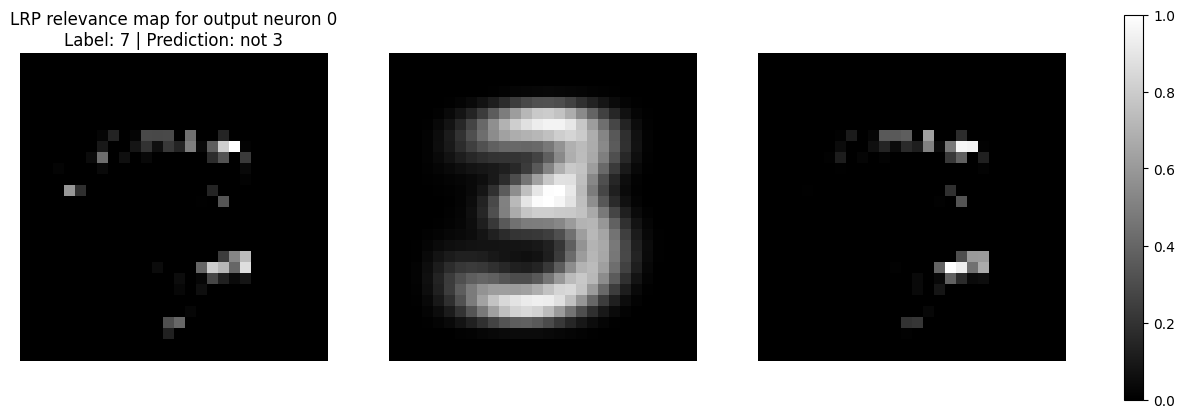

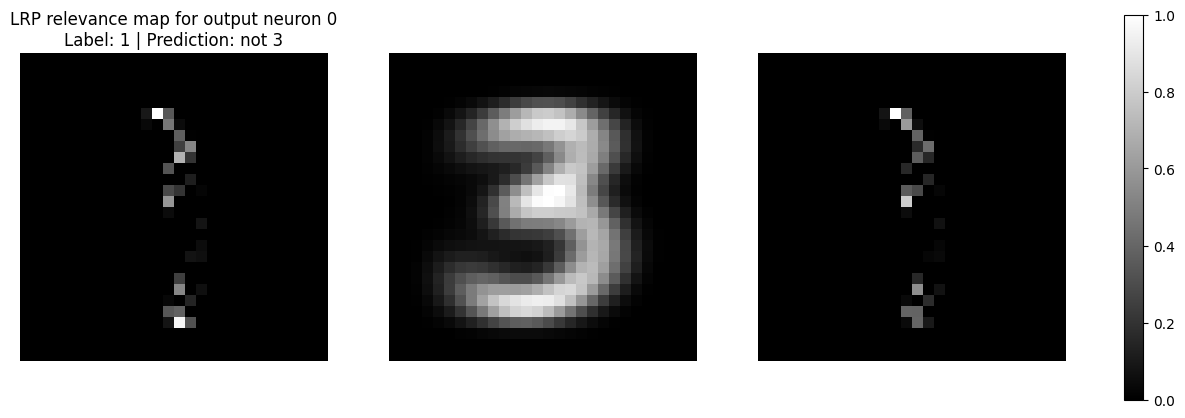

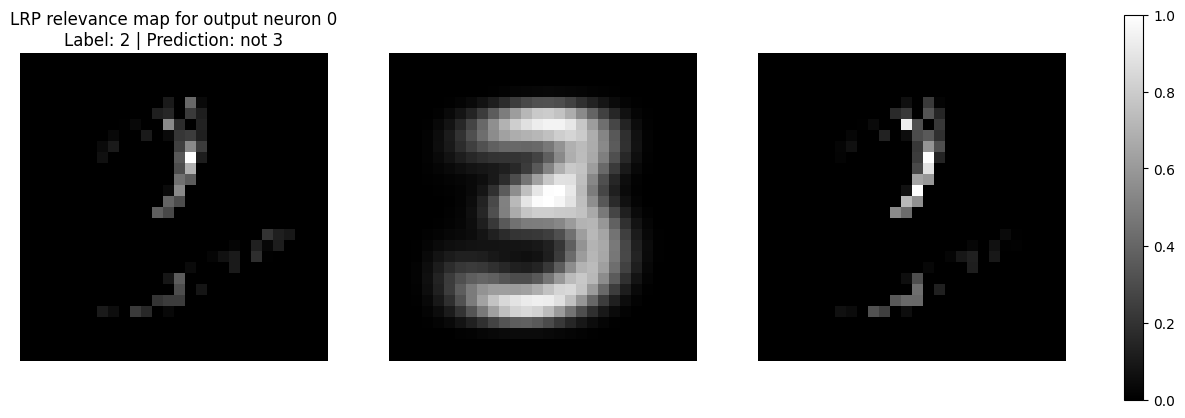

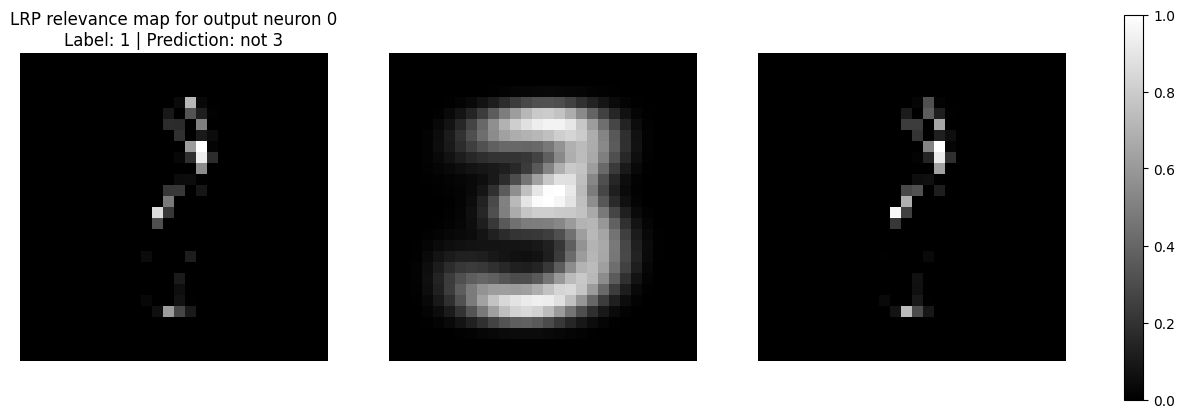

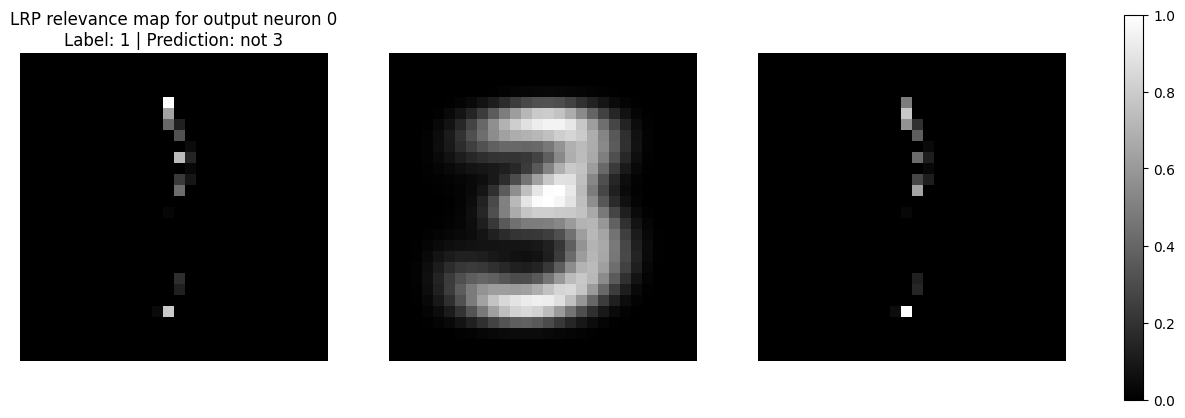

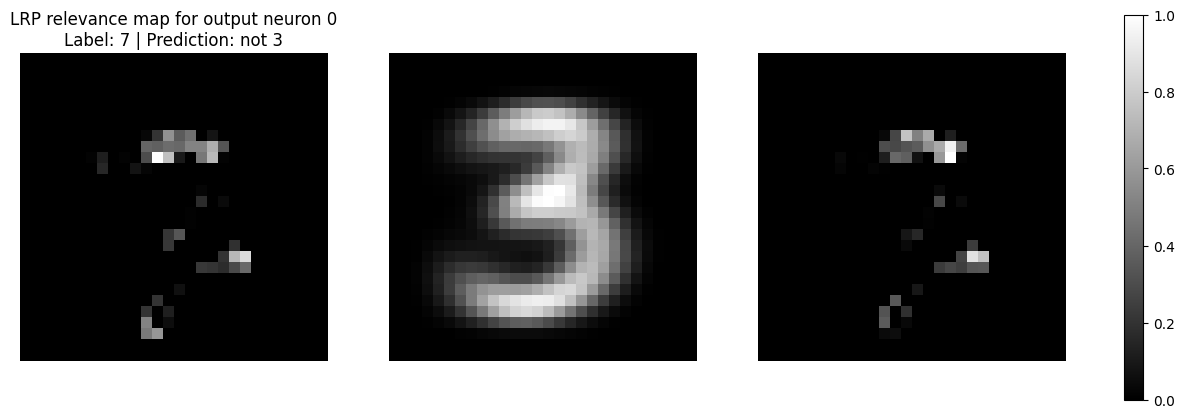

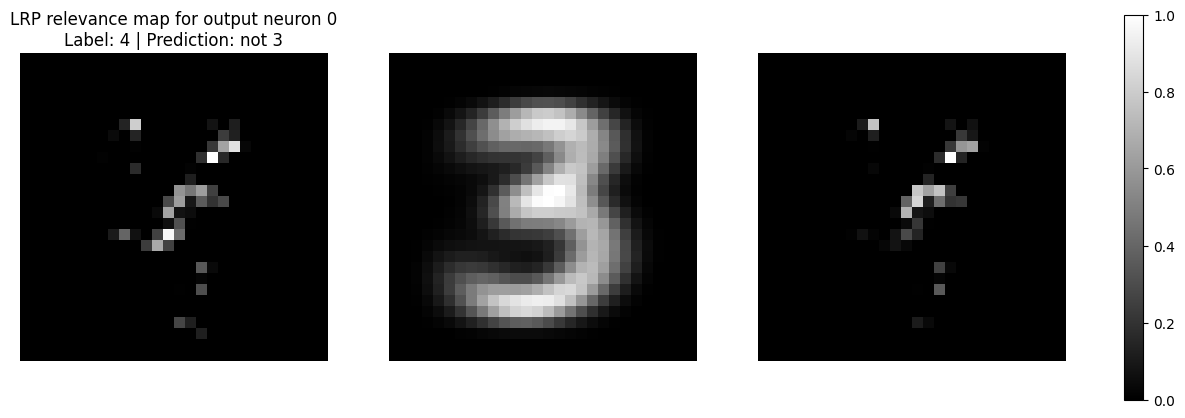

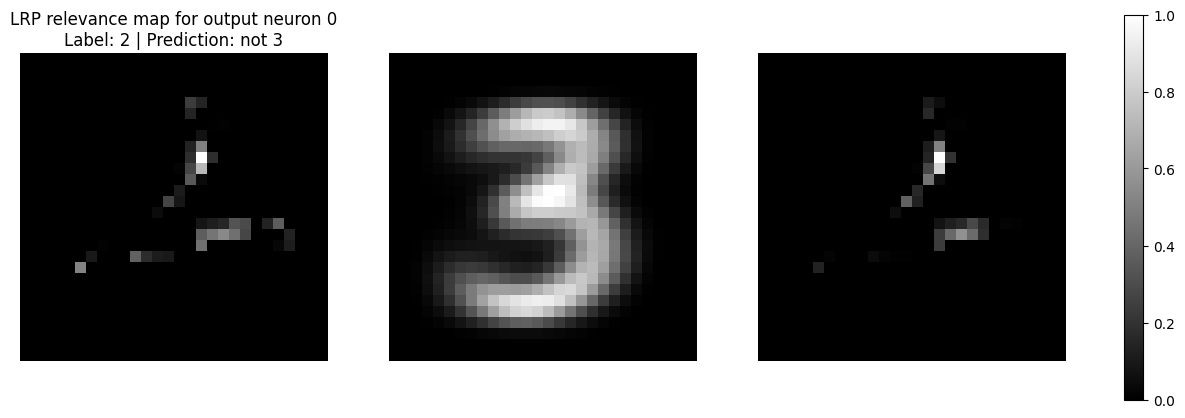

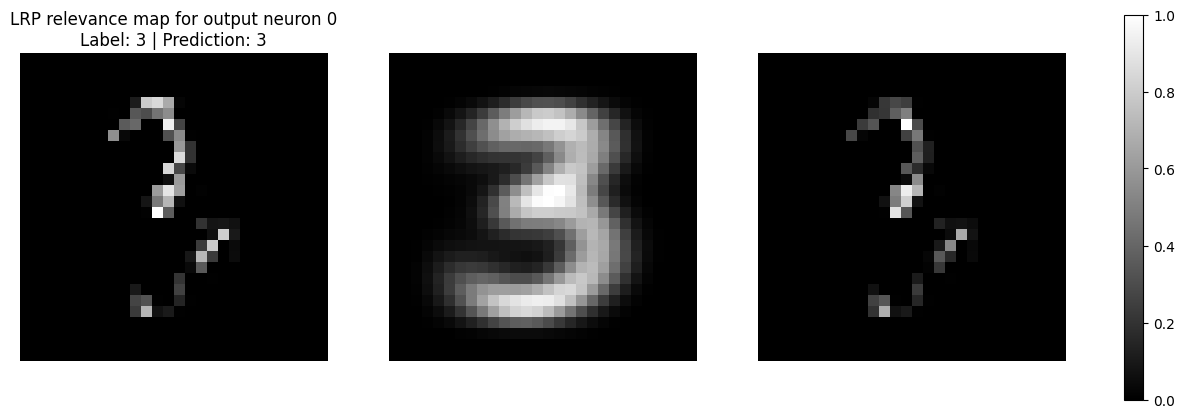

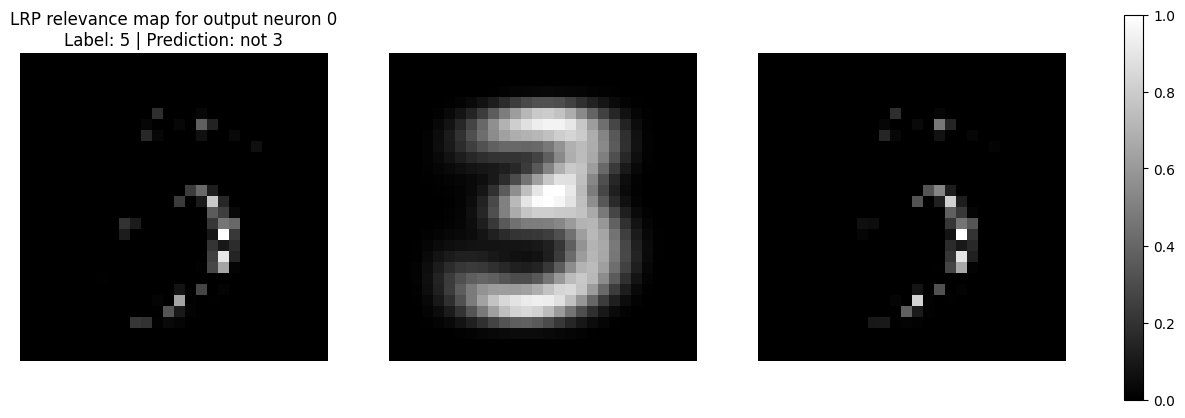

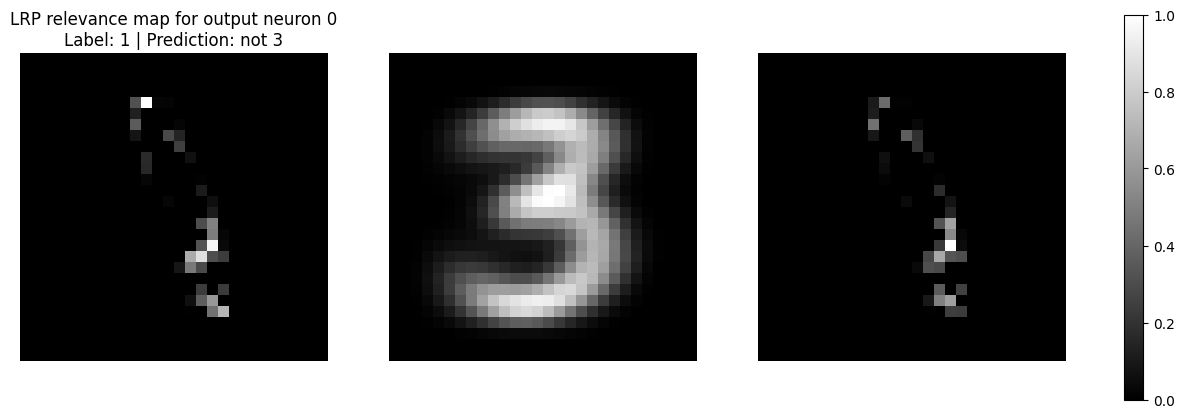

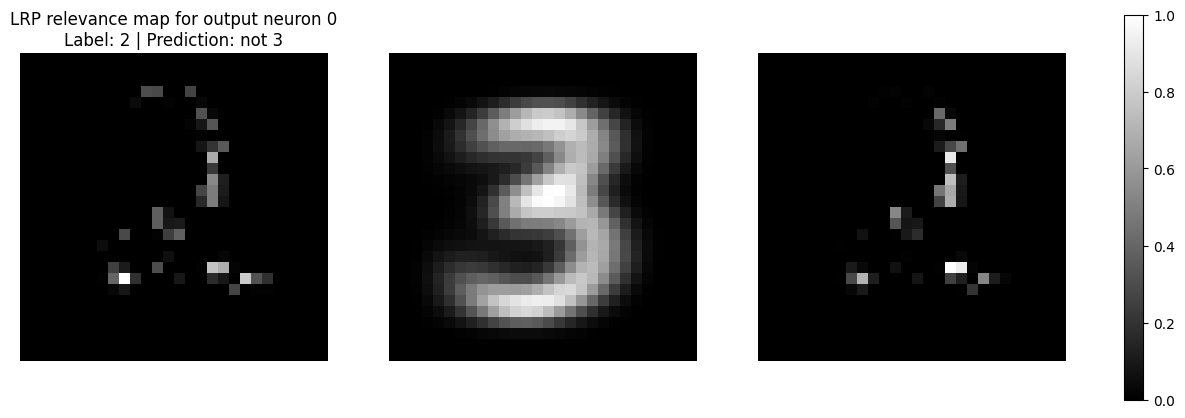

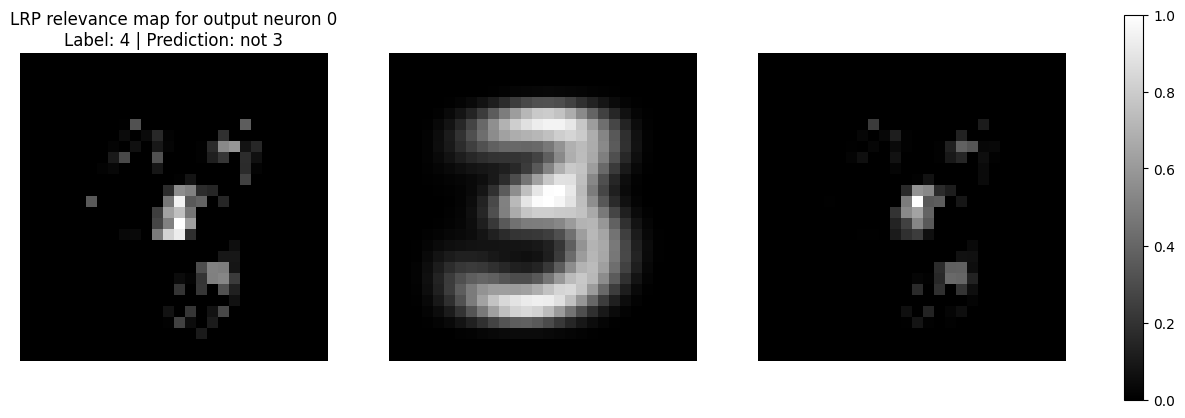

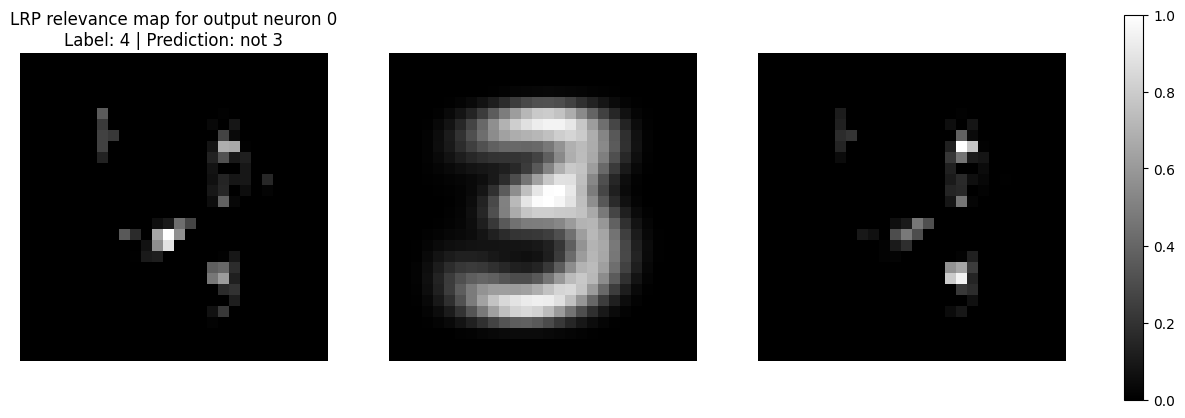

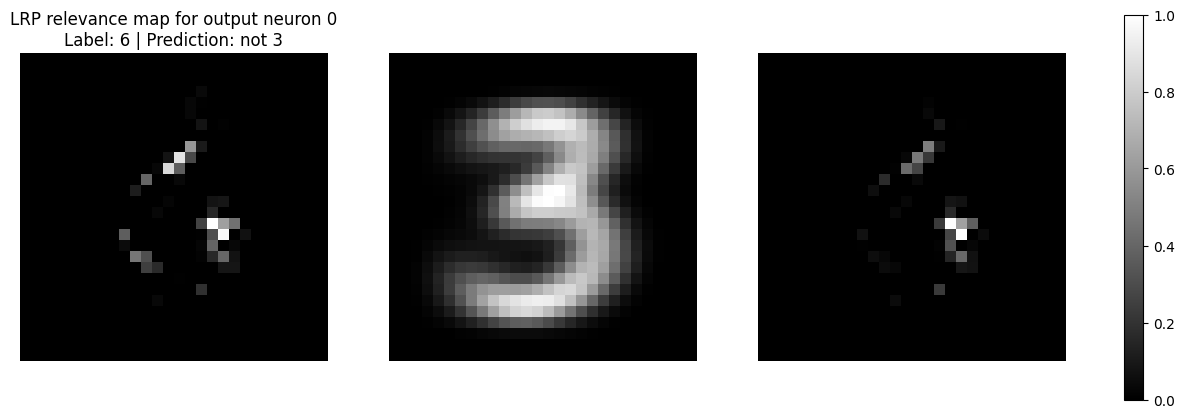

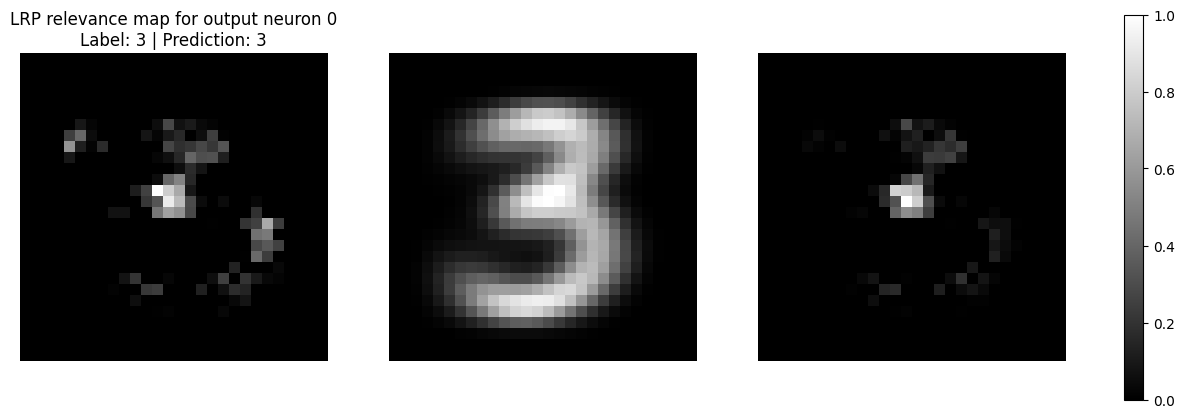

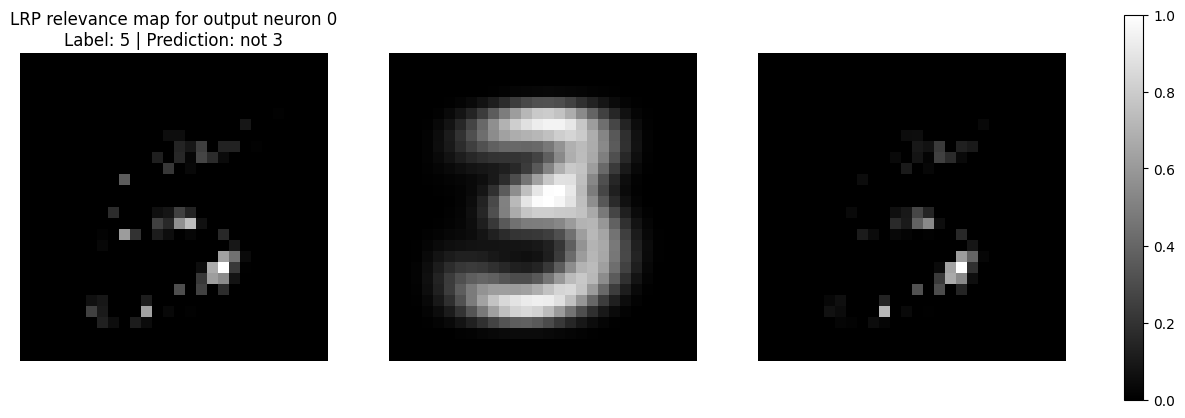

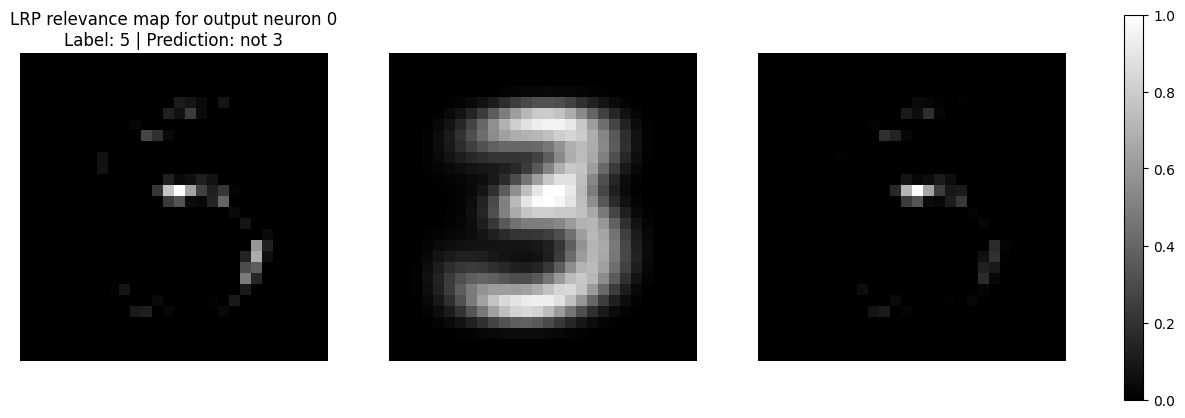

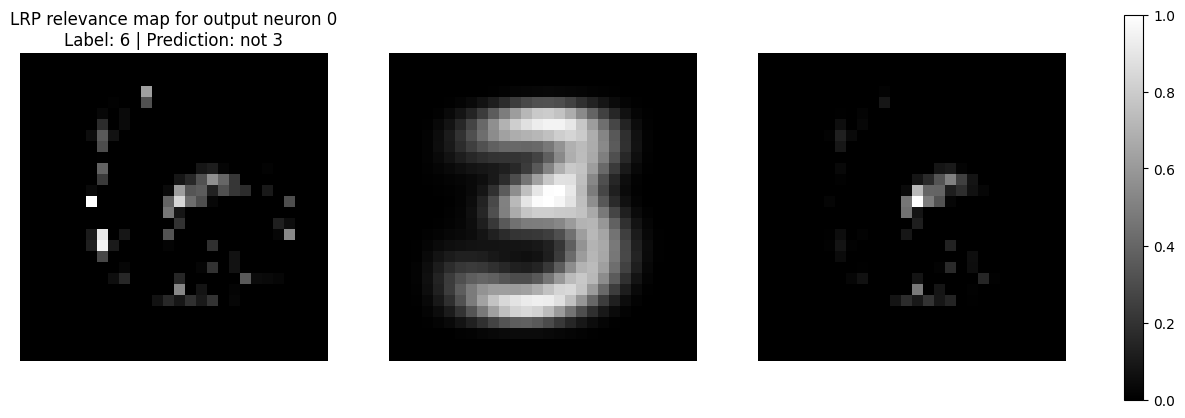

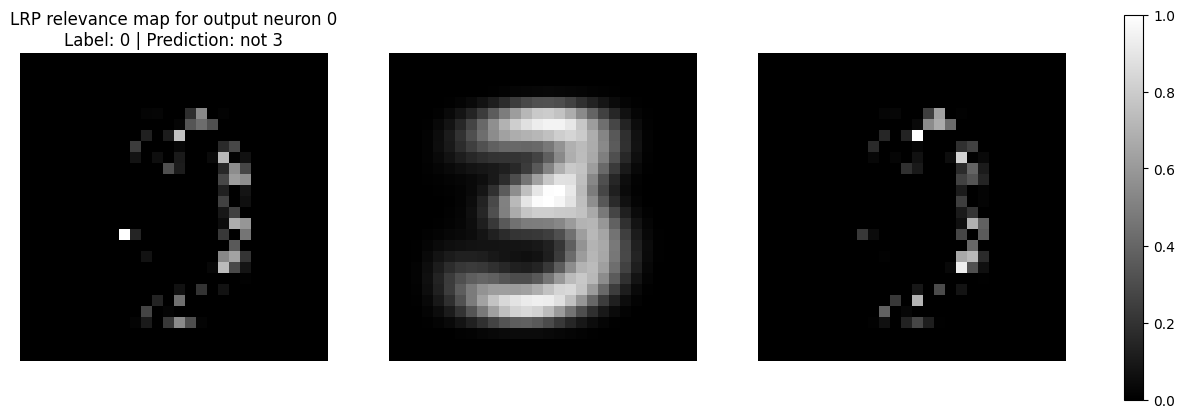

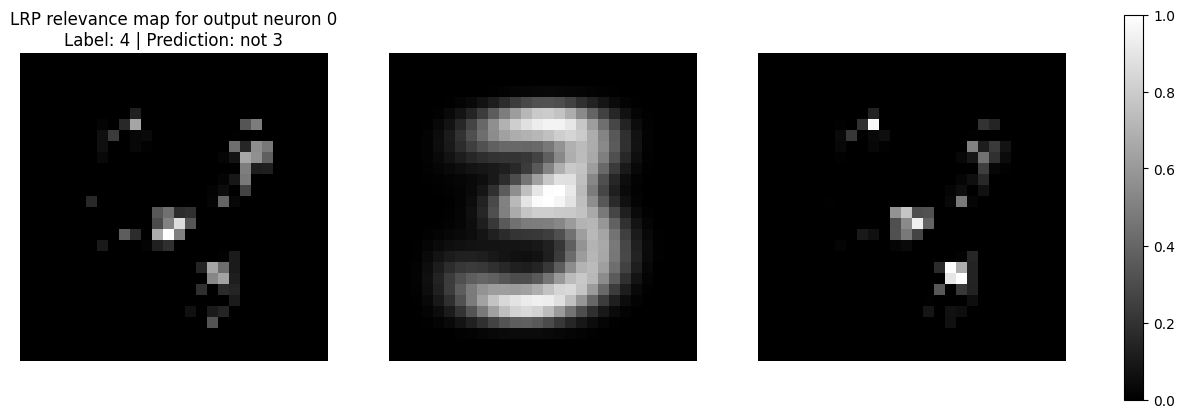

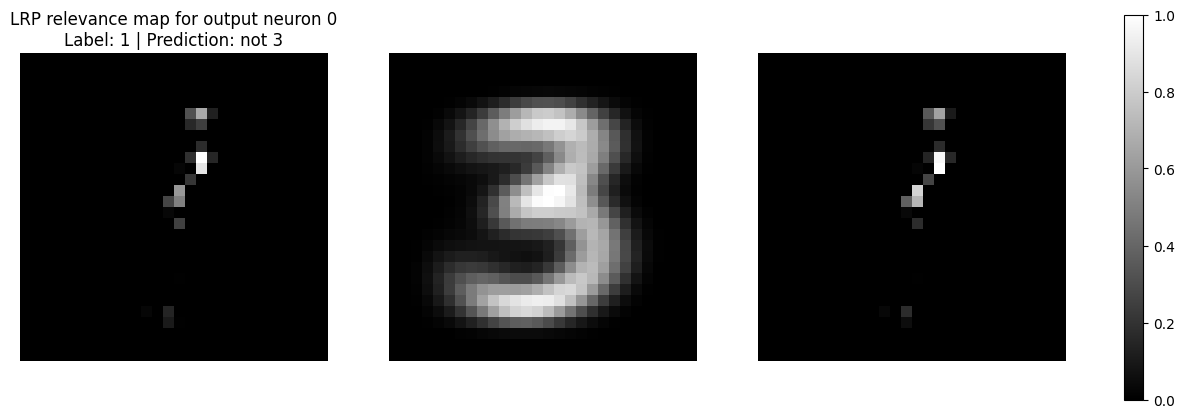

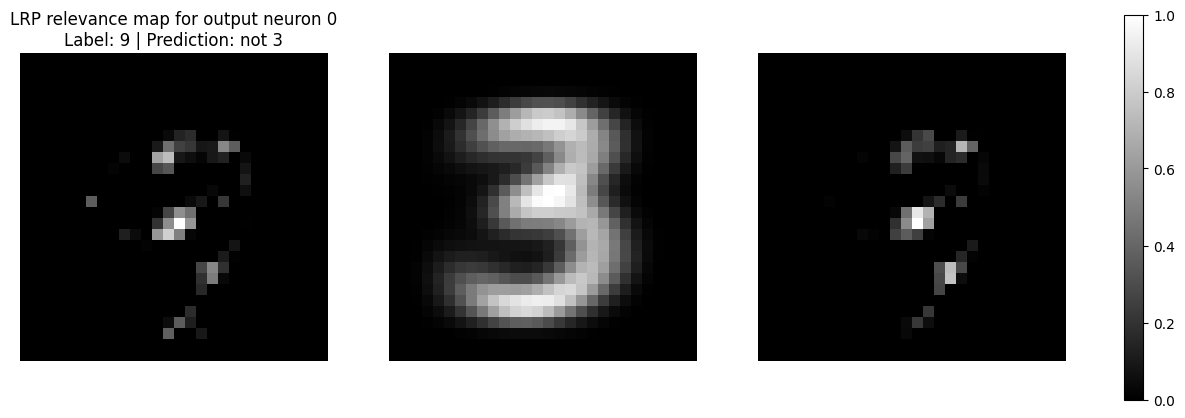

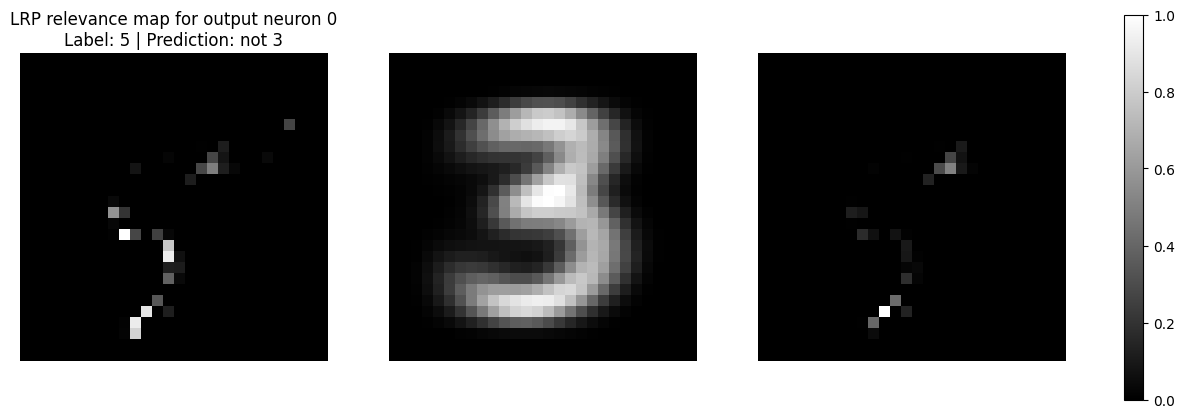

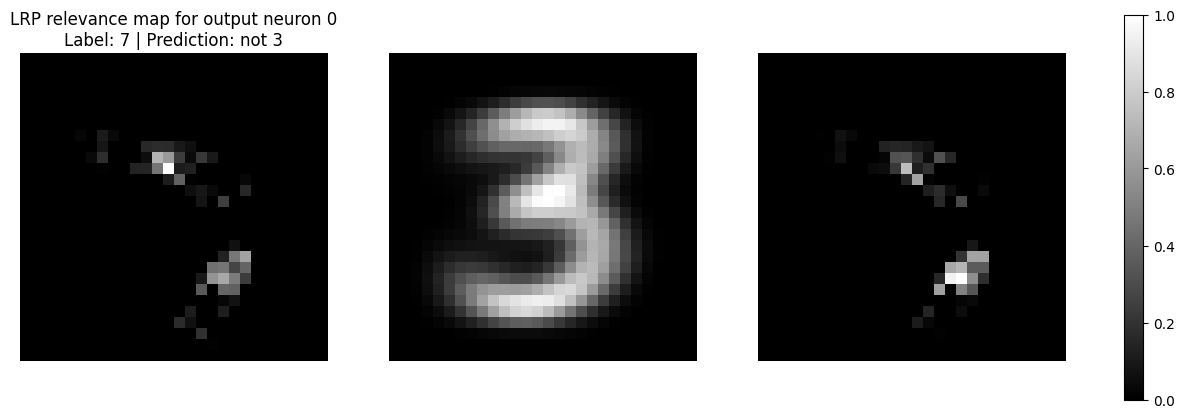

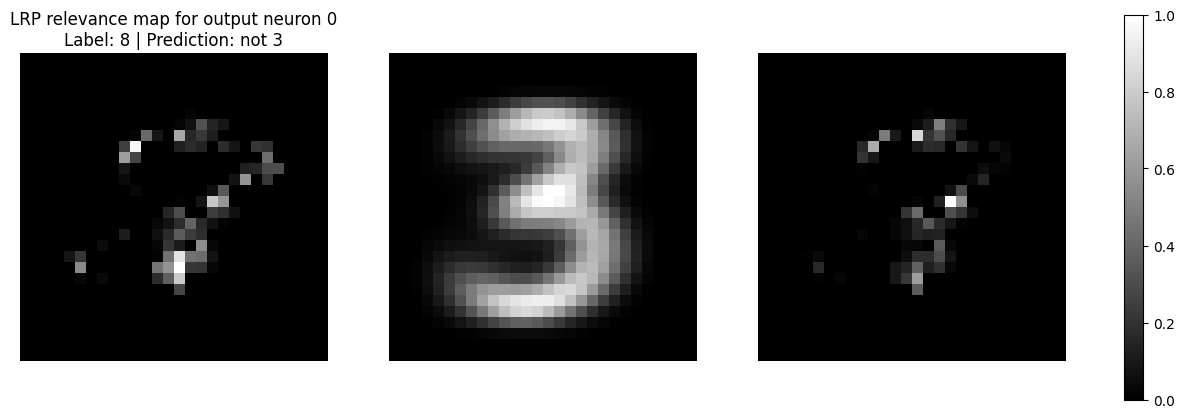

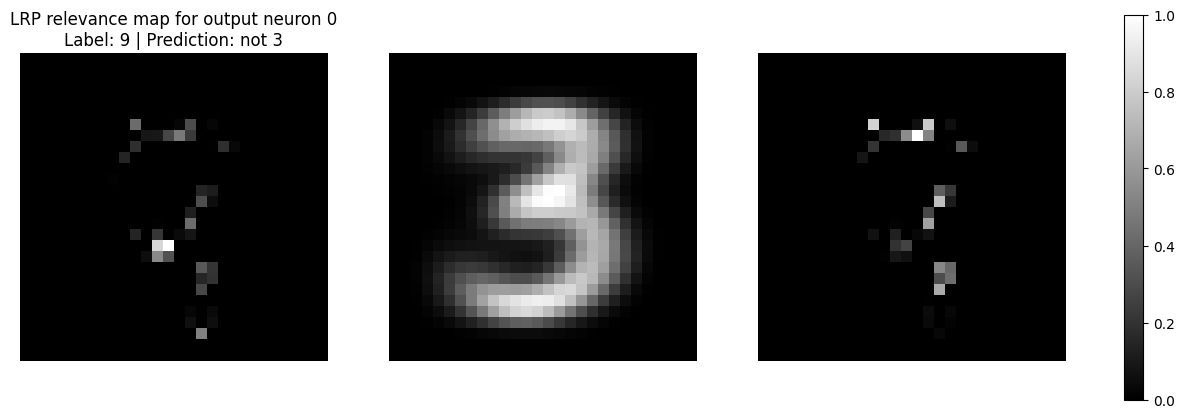

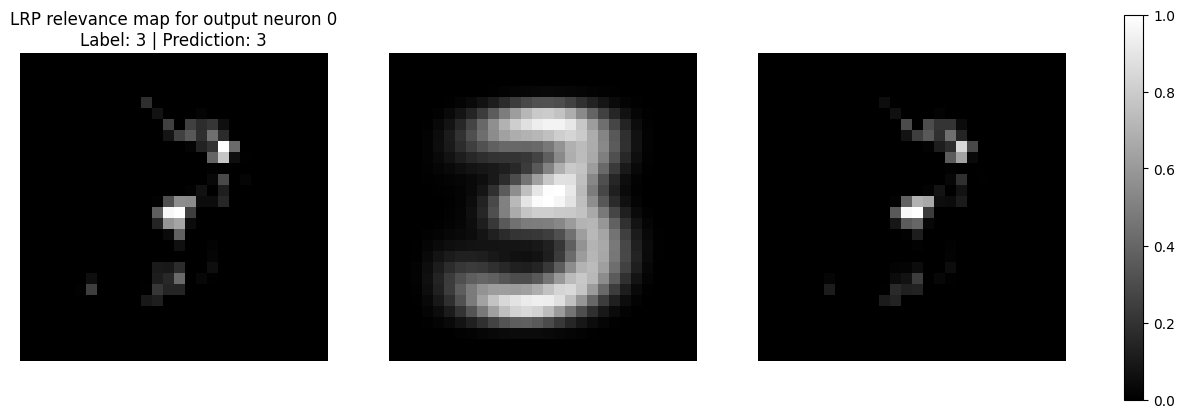

In [18]:
inputs, labels = next(iter(test_loader))
ind = ra.randrange(0, len(inputs))

for ind in range(len(inputs)):
    input = inputs[ind].unsqueeze(0).cuda()
    input.requires_grad_()

    label = labels[ind].item()

    net.eval()
    with torch.no_grad():
        output = net(input)
        prob = torch.sigmoid(output)
        prediction = (prob >= 0.5).int().item()



    lrp = LRP(net)
    target = torch.tensor(0).cuda() #which neuron, there is only one

    attributions = lrp.attribute(input, target=target)

    rel_map = attributions[0].cpu().detach().numpy().reshape(28, 28)

    with torch.no_grad():
        input_np = input[0].cpu().numpy().reshape(28, 28)  #input image

    background_mask = (input_np == 0)

    min_val = rel_map.min()

    rel_map[background_mask] = min_val

    rel_map = np.maximum(rel_map, 0)

    #normalise:
    rel_max = rel_map.max()
    rel_map /= rel_max

    average_max = average_img.max()
    average_img / average_max

    #get overlaps with average bin_digit:
    #mat_diff = 1 - (rel_map-average_img)
    #mat_avg = (abs(rel_map) + abs(average_img)) / 2
    #mat_diff *= -(mat_avg)

    mat_overlap = rel_map * average_img

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    ax1.imshow(rel_map, cmap='gray', interpolation='nearest')
    prediction = 1 - prediction
    ax1.set_title(f"LRP relevance map for output neuron {target.item()}\nLabel: {label} | Prediction:{' not'*prediction} {bin_digit}")
    ax1.axis('off')

    ax2.imshow(average_img, cmap="gray")
    ax2.axis('off')

    ax3.imshow(mat_overlap, cmap='gray', interpolation='nearest')
    ax3.axis('off')

    fig.colorbar(ax1.images[0], ax=[ax1, ax2, ax3], orientation='vertical', fraction=0.05)

    #plt.tight_layout()
    plt.show()




In [19]:
#activation maximisation:

In [20]:
import torch.nn.functional as F
import math

In [21]:
def maximize_neuron(model, layer: str, neuron_idx: int, steps=200, lr=0.1, l2_decay=1e-4):
    model.eval()
    img = torch.randn(1, 1, 28, 28, requires_grad=True, device=next(model.parameters()).device)
    optimizer = torch.optim.Adam([img], lr=lr)

    for _ in range(steps):
        optimizer.zero_grad()

        x = img.view(1, -1)
        x0 = model.relu(model.fc0(x))
        x1 = model.relu(model.fc1(x0))
        x2 = model.fc2(x1)             #logit out

        if layer == 'fc0':
            activation = x0[0, neuron_idx]
        elif layer == 'fc1':
            activation = x1[0, neuron_idx]
        elif layer == 'fc2':
            activation = x2[0, neuron_idx]
        else:
            raise ValueError("Invalid layer name")

        loss = -activation + l2_decay * (img ** 2).mean()
        loss.backward()
        optimizer.step()

    return img.detach().squeeze().cpu().clamp(0, 1)


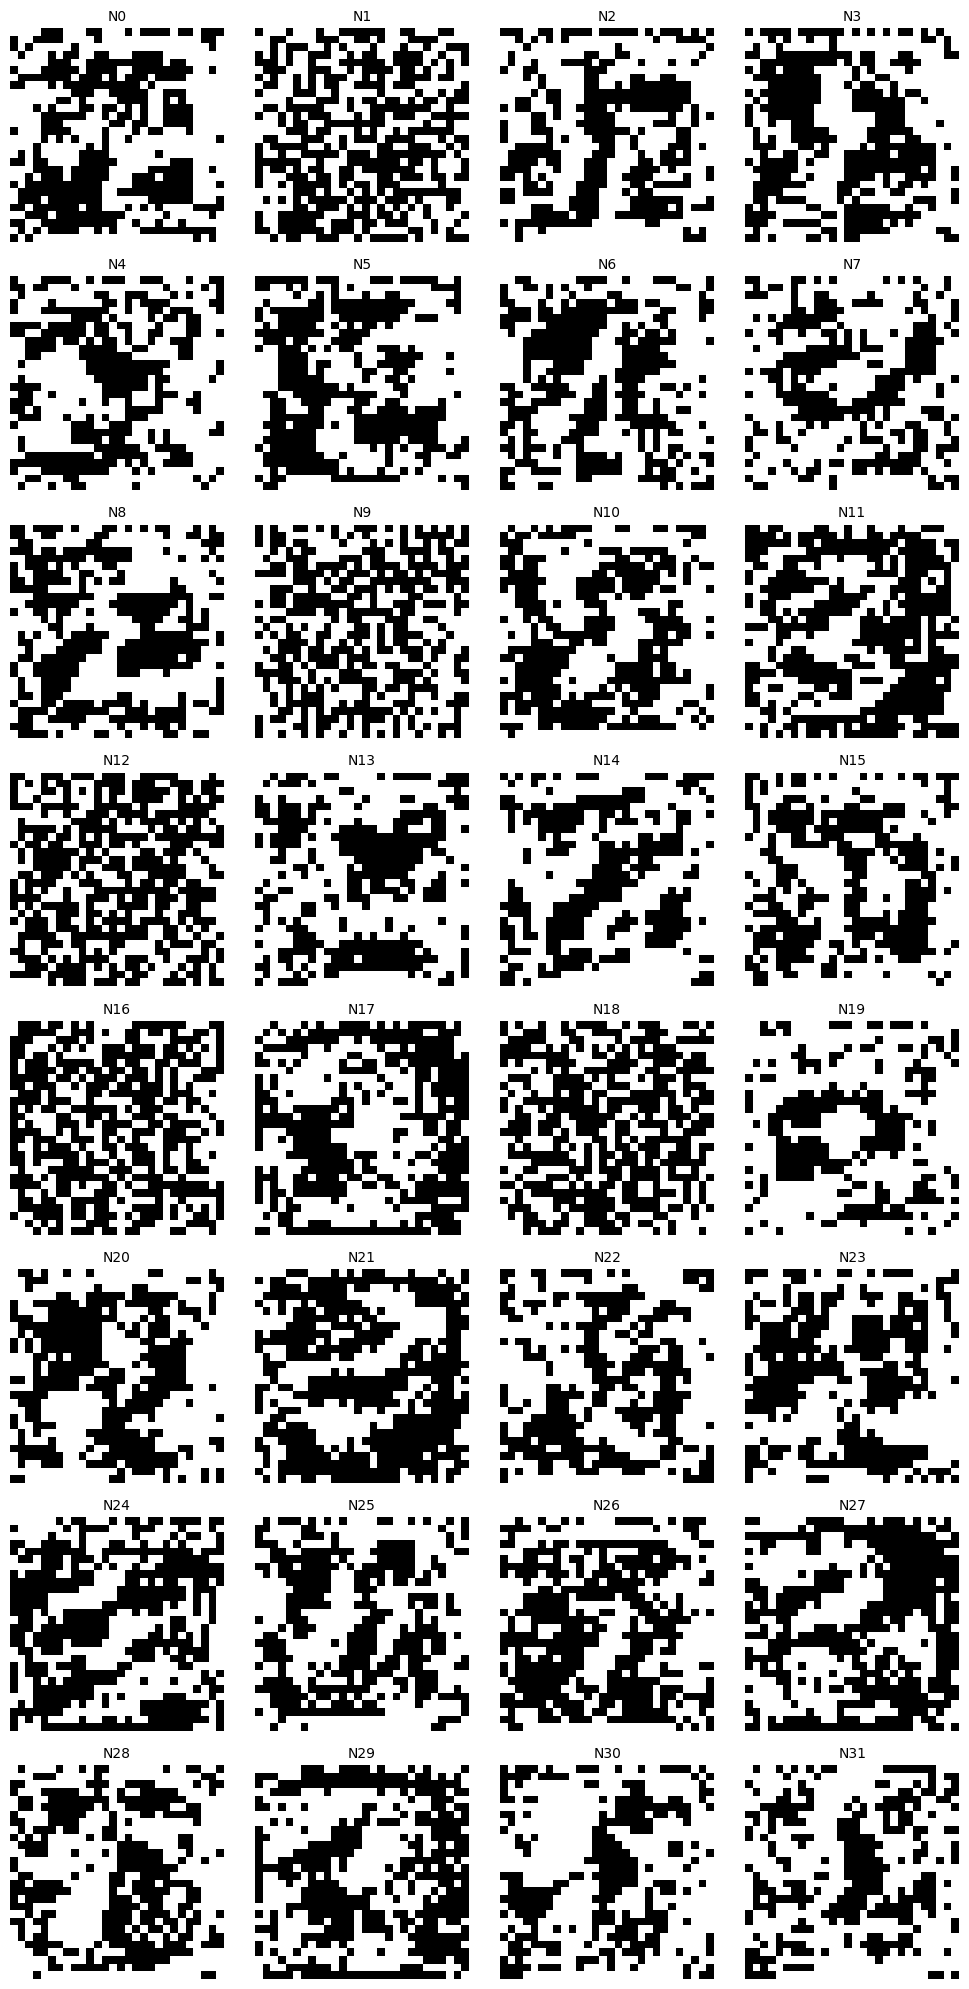

In [22]:
def plot_maximized_neurons(model, layer: str, num_neurons: int, cols: int = 4, img_size: float = 2.5):
    rows = math.ceil(num_neurons / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * img_size, rows * img_size))

    for i in range(rows * cols):
        ax = axes[i // cols, i % cols] if rows > 1 else axes[i]
        if i < num_neurons:
            img = maximize_neuron(model, layer, i)
            ax.imshow(img.numpy(), cmap='gray')
            ax.set_title(f'N{i}', fontsize=10)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

plot_maximized_neurons(net, layer='fc0', num_neurons=32)


In [23]:
inputs, labels = next(iter(test_loader))
ind = ra.randrange(0, len(inputs))

for ind in range(len(inputs)):
    input = inputs[ind].unsqueeze(0).cuda()
    input.requires_grad_()

    label = labels[ind].item()

    net.eval()
    with torch.no_grad():
        output = net(input)
        prob = torch.sigmoid(output)
        prediction = (prob >= 0.5).int().item()
        print(f"{output.item()} | {prob.item()}")

-6.170414924621582 | 0.0020860079675912857
-17.598426818847656 | 2.2756230677600797e-08
-11.33059310913086 | 1.1999985872535035e-05
-13.092070579528809 | 2.0615082121366868e-06
-17.336191177368164 | 2.9579295457438093e-08
-13.5938720703125 | 1.248118564944889e-06
-21.37680435180664 | 5.202017705485673e-10
-5.834157943725586 | 0.002917350037023425
-15.590506553649902 | 1.6948409609085502e-07
-16.032203674316406 | 1.0896884106159632e-07
-16.802473068237305 | 5.0440416288211054e-08
-11.381054878234863 | 1.140947551903082e-05
-14.701138496398926 | 4.124549377593212e-07
-15.380800247192383 | 2.0902741937334213e-07
-15.00500774383545 | 3.0437419695772405e-07
-5.553080081939697 | 0.003860540222376585
-18.400264739990234 | 1.0206258060918572e-08
-8.799600601196289 | 0.00015077056013979018
2.734072208404541 | 0.9390074610710144
-17.99262046813965 | 1.534278659676147e-08
-18.075586318969727 | 1.4121233071762163e-08
-14.1990385055542 | 6.814526045673119e-07
-14.723651885986328 | 4.032729350456065

In [24]:
#output above shows that model is very confident, important to note. Value are either close to 0 or 1, sigmoid range from 0 to 1!

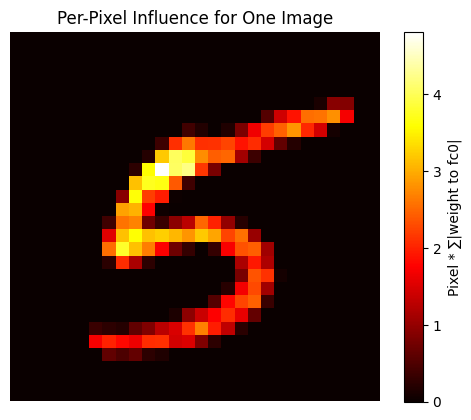

In [25]:
import matplotlib.pyplot as plt
import random as ra

inputs, labels = next(iter(test_loader))
ind = ra.randrange(0, len(inputs))
img = inputs[ind].squeeze() #[28, 28]

weights = net.fc0.weight.detach().cpu() #[32, 784]
importance = weights.abs().sum(dim=0).view(28, 28) #[28, 28]

influence = img * importance #[28, 28] 

plt.imshow(influence, cmap='hot', vmin=0, vmax=influence.max())
plt.colorbar(label='Pixel * ∑|weight to fc0|')
plt.title('Per-Pixel Influence for One Image')
plt.axis('off')
plt.show()